# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
from __future__ import print_function, division

import os
import numpy as np
import pandas as pd
import copy
import time
import random
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# https://github.com/Cadene/pretrained-models.pytorch
# pip install pretrainedmodels
import pretrainedmodels
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [3]:
print(pretrainedmodels.pretrained_settings['inceptionresnetv2'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}, 'imagenet+background': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1001}}


In [4]:
# see https://github.com/pytorch/pytorch/issues/7068
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is available!  Training on GPU ...


In [6]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        torchfcn.models.FCN32s,
        torchfcn.models.FCN16s,
        torchfcn.models.FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))

In [7]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    
    if isinstance(image, torch.Tensor): image = copy.deepcopy(image.numpy())
        
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if isinstance(image, np.ndarray):     # type(image).__module__ == "numpy":    #
        image = image.transpose((1, 2, 0))
    else:
        image = image.numpy.transpose((1, 2, 0))
    
    
    if normalize:
        # Undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
        image = np.clip(image, 0, 1)

    if title is not None:
        ax.set_title(title)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [8]:
batch_size = 64
num_workers = 4

### See for test data : https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad

In [10]:
data_dir = 'flowers'   #'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir  = data_dir + '/test'

In [11]:
# TODO: Define your transforms for the training and validation sets
# Original transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                #       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05), 
                                #       transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                                       transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                ]),
    'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])    
}

In [12]:
# Load the datasets with ImageFolder and transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [13]:
# Define the dataloaders, using the image datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=False if x=='test' else True, 
                                              num_workers=num_workers)
              for x in ['train', 'valid', 'test']}

In [14]:
dataset_sizes

{'train': 6552, 'valid': 818, 'test': 819}

In [15]:
len(class_names)

102

In [16]:
class_names[:10], class_names[-10:]

(['1', '10', '100', '101', '102', '11', '12', '13', '14', '15'],
 ['90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [17]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

class_to_idx = dataloaders['train'].dataset.class_to_idx

idx_to_class =  {y:x for x,y in class_to_idx.items()}

In [18]:
for flower in sorted(cat_to_name.items(), key=lambda x: int(x[0])):
    print(flower)

('1', 'pink primrose')
('2', 'hard-leaved pocket orchid')
('3', 'canterbury bells')
('4', 'sweet pea')
('5', 'english marigold')
('6', 'tiger lily')
('7', 'moon orchid')
('8', 'bird of paradise')
('9', 'monkshood')
('10', 'globe thistle')
('11', 'snapdragon')
('12', "colt's foot")
('13', 'king protea')
('14', 'spear thistle')
('15', 'yellow iris')
('16', 'globe-flower')
('17', 'purple coneflower')
('18', 'peruvian lily')
('19', 'balloon flower')
('20', 'giant white arum lily')
('21', 'fire lily')
('22', 'pincushion flower')
('23', 'fritillary')
('24', 'red ginger')
('25', 'grape hyacinth')
('26', 'corn poppy')
('27', 'prince of wales feathers')
('28', 'stemless gentian')
('29', 'artichoke')
('30', 'sweet william')
('31', 'carnation')
('32', 'garden phlox')
('33', 'love in the mist')
('34', 'mexican aster')
('35', 'alpine sea holly')
('36', 'ruby-lipped cattleya')
('37', 'cape flower')
('38', 'great masterwort')
('39', 'siam tulip')
('40', 'lenten rose')
('41', 'barbeton daisy')
('42', 

In [19]:
class_to_idx['7']

69

In [20]:
idx_to_class[69]

'7'

In [21]:
[(k, v) for k, v in class_to_idx.items()][:10]

[('1', 0),
 ('10', 1),
 ('100', 2),
 ('101', 3),
 ('102', 4),
 ('11', 5),
 ('12', 6),
 ('13', 7),
 ('14', 8),
 ('15', 9)]

In [22]:
[(k, v) for k, v in idx_to_class.items()][:10]

[(0, '1'),
 (1, '10'),
 (2, '100'),
 (3, '101'),
 (4, '102'),
 (5, '11'),
 (6, '12'),
 (7, '13'),
 (8, '14'),
 (9, '15')]

# Data exploration

In [23]:
image_datasets["train"].imgs[20:35]

[('flowers\\train\\1\\image_06766.jpg', 0),
 ('flowers\\train\\1\\image_06767.jpg', 0),
 ('flowers\\train\\1\\image_06768.jpg', 0),
 ('flowers\\train\\1\\image_06770.jpg', 0),
 ('flowers\\train\\1\\image_06771.jpg', 0),
 ('flowers\\train\\1\\image_06772.jpg', 0),
 ('flowers\\train\\1\\image_06773.jpg', 0),
 ('flowers\\train\\10\\image_07086.jpg', 1),
 ('flowers\\train\\10\\image_07087.jpg', 1),
 ('flowers\\train\\10\\image_07088.jpg', 1),
 ('flowers\\train\\10\\image_07089.jpg', 1),
 ('flowers\\train\\10\\image_07091.jpg', 1),
 ('flowers\\train\\10\\image_07092.jpg', 1),
 ('flowers\\train\\10\\image_07093.jpg', 1),
 ('flowers\\train\\10\\image_07095.jpg', 1)]

In [24]:
images, labels = next(iter(dataloaders['train']))

In [25]:
images.size(0), labels.size(0)

(64, 64)

In [26]:
labels

tensor([ 74,  74,  71,  90,  54,  90,  40,  26,  22,  96,  14,  78, 100,   0,
         24,  49,  16,  86,  78,  73,  98,   5,  58,  31,  55,   6,  40,  39,
         35,  23,   8,  49,  54,  55,  91,  41,  46,  26,  93,  49,  43,  77,
         23,  35,  69,  84,  86,  91,  91,  43,  64,  52,  64,  63,  24,  90,
         56,  77,  89,  79,  21,  90,  58,  88])

In [27]:
idx_to_class[2], cat_to_name[idx_to_class[2]]

('100', 'blanket flower')

In [28]:
idx_to_class[0], cat_to_name[idx_to_class[0]]

('1', 'pink primrose')

In [29]:
idx_to_class[69], cat_to_name[idx_to_class[69]]

('7', 'moon orchid')

In [30]:
idx_to_class[66], cat_to_name[idx_to_class[66]]

('67', 'spring crocus')

In [31]:
class_to_idx['77'], cat_to_name['77']

(77, 'passion flower')

In [32]:
idx_to_class[77], cat_to_name[idx_to_class[77]]

('77', 'passion flower')

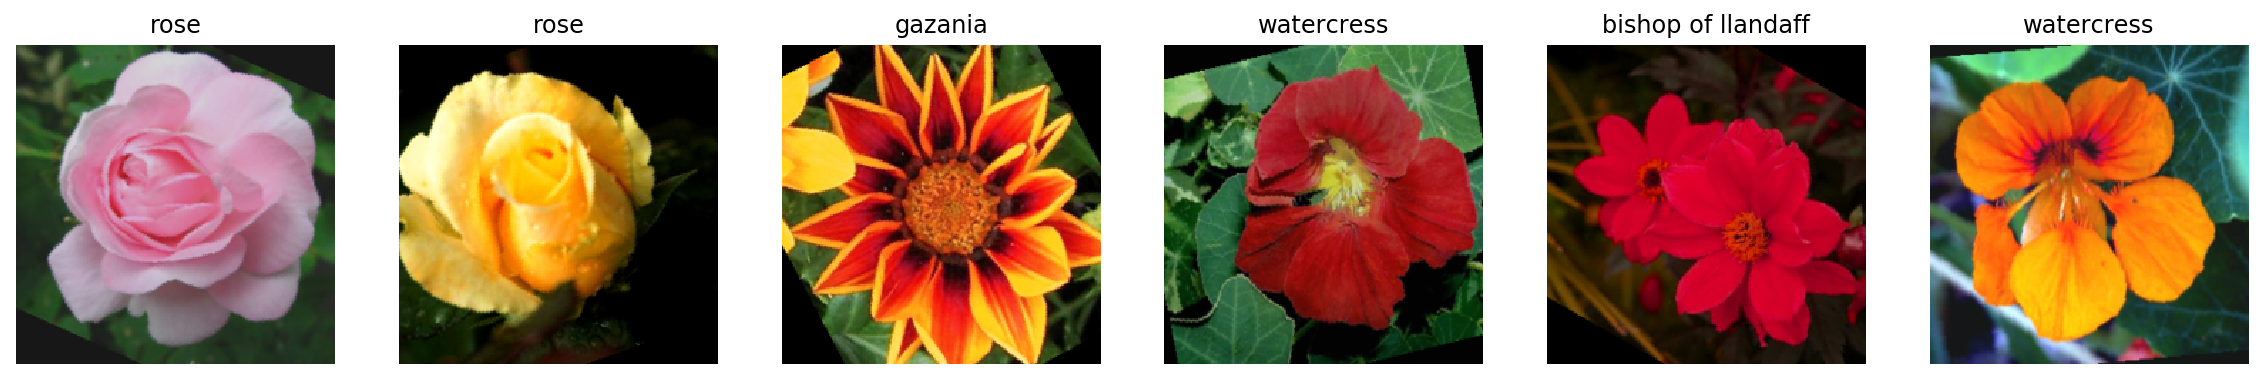

In [33]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, normalize=True)

In [34]:
image_datasets["valid"].imgs[:15]

[('flowers\\valid\\1\\image_06739.jpg', 0),
 ('flowers\\valid\\1\\image_06749.jpg', 0),
 ('flowers\\valid\\1\\image_06755.jpg', 0),
 ('flowers\\valid\\1\\image_06756.jpg', 0),
 ('flowers\\valid\\1\\image_06758.jpg', 0),
 ('flowers\\valid\\1\\image_06763.jpg', 0),
 ('flowers\\valid\\1\\image_06765.jpg', 0),
 ('flowers\\valid\\1\\image_06769.jpg', 0),
 ('flowers\\valid\\10\\image_07094.jpg', 1),
 ('flowers\\valid\\10\\image_07101.jpg', 1),
 ('flowers\\valid\\10\\image_07102.jpg', 1),
 ('flowers\\valid\\10\\image_07107.jpg', 1),
 ('flowers\\valid\\100\\image_07895.jpg', 2),
 ('flowers\\valid\\100\\image_07904.jpg', 2),
 ('flowers\\valid\\100\\image_07905.jpg', 2)]

In [35]:
images, labels = next(iter(dataloaders['valid']))

In [36]:
labels

tensor([ 93,  84,  75,  68,  59,  89,  56,  57,  89,  50,  10,  30,  73,  84,
         50,  81,  77,  14,  54,  33,  57,  87,  31, 101,  49,  95,  59,  99,
         86,  63,  48,  71,  47,  38,   5,  82,  64,  29,  81,  79,  56,  90,
         25,   3,  49,  71,  66,  81,  46,  29,   6,  32,   0, 101,  45,  40,
         85,   5,  83,  96,  96,  75,  13,  53])

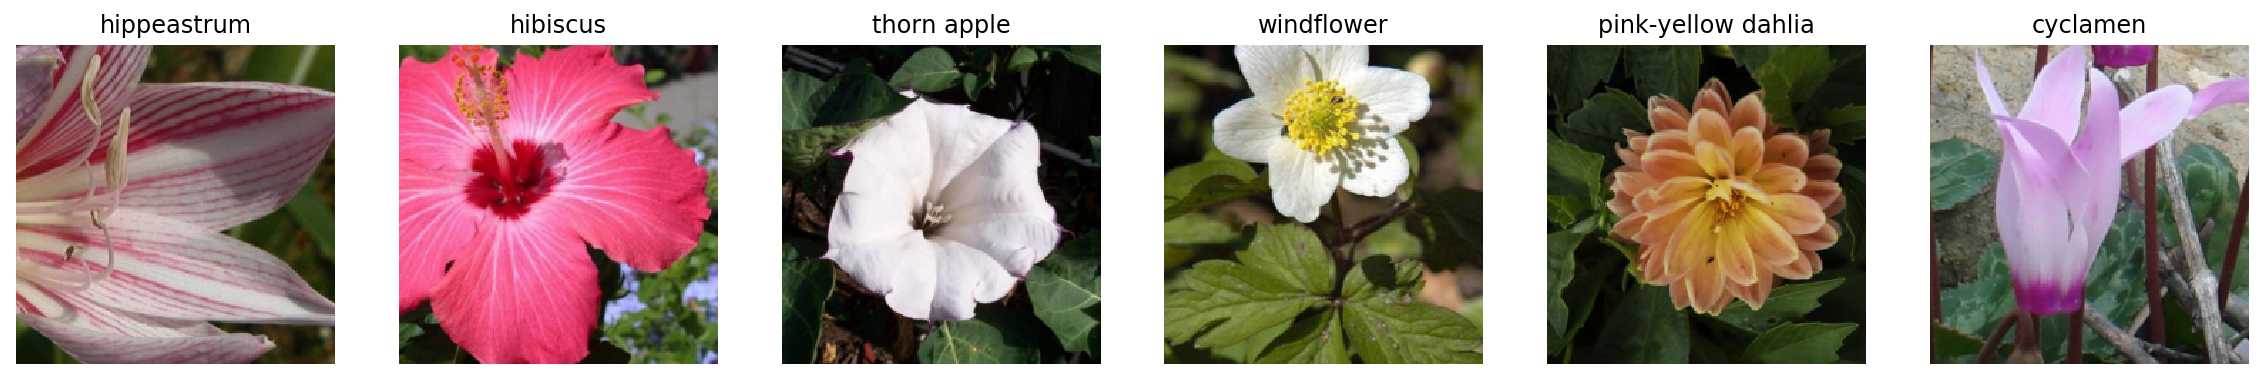

In [37]:
fig, axes = plt.subplots(figsize=(20,6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, normalize=True)

In [38]:
image_datasets["test"].imgs[:15]

[('flowers\\test\\1\\image_06743.jpg', 0),
 ('flowers\\test\\1\\image_06752.jpg', 0),
 ('flowers\\test\\1\\image_06754.jpg', 0),
 ('flowers\\test\\1\\image_06760.jpg', 0),
 ('flowers\\test\\1\\image_06764.jpg', 0),
 ('flowers\\test\\10\\image_07090.jpg', 1),
 ('flowers\\test\\10\\image_07104.jpg', 1),
 ('flowers\\test\\10\\image_07117.jpg', 1),
 ('flowers\\test\\100\\image_07896.jpg', 2),
 ('flowers\\test\\100\\image_07897.jpg', 2),
 ('flowers\\test\\100\\image_07899.jpg', 2),
 ('flowers\\test\\100\\image_07902.jpg', 2),
 ('flowers\\test\\100\\image_07926.jpg', 2),
 ('flowers\\test\\100\\image_07936.jpg', 2),
 ('flowers\\test\\100\\image_07938.jpg', 2)]

In [39]:
images, labels = next(iter(dataloaders['test']))

In [40]:
labels

tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,
         9,  9,  9, 10, 10, 10, 11, 11, 11, 11])

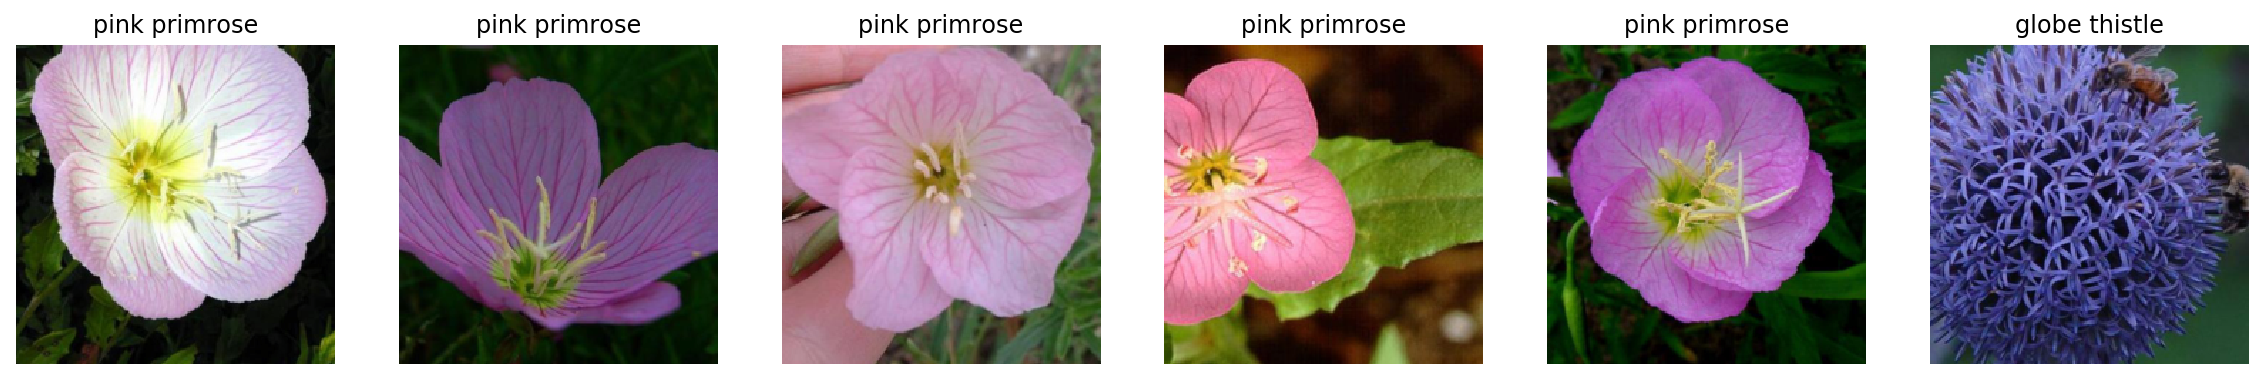

In [41]:
fig, axes = plt.subplots(figsize=(20,6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, normalize=True)

In [42]:
from pathlib import Path

def folders_in_path(path):
    if not Path.is_dir(path):
        raise ValueError("argument is not a directory")
    yield from filter(Path.is_dir, path.iterdir())

def folders_in_depth(path, depth):
    if 0 > depth:
        raise ValueError("depth smaller 0")
    if 0 == depth:
        yield from folders_in_path(path)
    else:
        for folder in folders_in_path(path):
            yield from folders_in_depth(folder, depth-1)

def files_in_path(path):
    if not Path.is_dir(path):
        raise ValueError("argument is not a directory")
    yield from filter(Path.is_file, path.iterdir())
    
def sum_file_size(filepaths):
    return sum([filep.stat().st_size for filep in filepaths])


In [43]:
files_per_folder = []
for folder in folders_in_depth(Path.cwd()/train_dir,0):
    files = list(files_in_path(folder))
    foldername = os.path.basename(os.path.normpath(folder))
    files_per_folder.append((foldername, cat_to_name[foldername], len(files)))
    
print("Training data files per class:")
print("-----------------------------------")
for flower in sorted(files_per_folder, key=lambda x: int(x[0])):
    print('{:<3} {:<25} {:>5}'.format(flower[0], flower[1], flower[2]))

Training data files per class:
-----------------------------------
1   pink primrose                27
2   hard-leaved pocket orchid    49
3   canterbury bells             36
4   sweet pea                    44
5   english marigold             54
6   tiger lily                   35
7   moon orchid                  33
8   bird of paradise             70
9   monkshood                    41
10  globe thistle                38
11  snapdragon                   68
12  colt's foot                  73
13  king protea                  38
14  spear thistle                44
15  yellow iris                  38
16  globe-flower                 36
17  purple coneflower            60
18  peruvian lily                65
19  balloon flower               38
20  giant white arum lily        46
21  fire lily                    34
22  pincushion flower            47
23  fritillary                   72
24  red ginger                   35
25  grape hyacinth               34
26  corn poppy                   

### Set weights to try and deal with class imbalance...

In [44]:
class_counts = defaultdict(int)
for _, c in image_datasets["train"].imgs:
    class_counts[c] += 1

class_weights = [1-(float(class_counts[class_id])/len(image_datasets["train"].imgs))
                 for class_id in range(len(image_datasets["train"].classes))]
class_weights = torch.FloatTensor(class_weights)
class_weights.to(device)

tensor([0.9959, 0.9942, 0.9947, 0.9925, 0.9945, 0.9896, 0.9889, 0.9942, 0.9933,
        0.9942, 0.9945, 0.9908, 0.9901, 0.9942, 0.9925, 0.9930, 0.9948, 0.9928,
        0.9890, 0.9947, 0.9948, 0.9950, 0.9945, 0.9916, 0.9905, 0.9945, 0.9907,
        0.9927, 0.9945, 0.9953, 0.9957, 0.9950, 0.9905, 0.9860, 0.9933, 0.9950,
        0.9933, 0.9918, 0.9852, 0.9925, 0.9847, 0.9889, 0.9950, 0.9760, 0.9907,
        0.9913, 0.9942, 0.9918, 0.9889, 0.9686, 0.9898, 0.9893, 0.9928, 0.9915,
        0.9860, 0.9924, 0.9869, 0.9915, 0.9947, 0.9870, 0.9945, 0.9927, 0.9936,
        0.9936, 0.9866, 0.9922, 0.9945, 0.9934, 0.9930, 0.9950, 0.9922, 0.9902,
        0.9882, 0.9776, 0.9783, 0.9855, 0.9873, 0.9687, 0.9829, 0.9948, 0.9893,
        0.9875, 0.9794, 0.9875, 0.9841, 0.9899, 0.9927, 0.9927, 0.9922, 0.9823,
        0.9766, 0.9937, 0.9899, 0.9910, 0.9919, 0.9948, 0.9799, 0.9846, 0.9890,
        0.9918, 0.9896, 0.9924], device='cuda:0')

In [45]:
class_counts

defaultdict(int,
            {0: 27,
             1: 38,
             2: 35,
             3: 49,
             4: 36,
             5: 68,
             6: 73,
             7: 38,
             8: 44,
             9: 38,
             10: 36,
             11: 60,
             12: 65,
             13: 38,
             14: 49,
             15: 46,
             16: 34,
             17: 47,
             18: 72,
             19: 35,
             20: 34,
             21: 33,
             22: 36,
             23: 55,
             24: 62,
             25: 36,
             26: 61,
             27: 48,
             28: 36,
             29: 31,
             30: 28,
             31: 33,
             32: 62,
             33: 92,
             34: 44,
             35: 33,
             36: 44,
             37: 54,
             38: 97,
             39: 49,
             40: 100,
             41: 73,
             42: 33,
             43: 157,
             44: 61,
             45: 57,
             46: 38,
    

In [46]:
class_weights

tensor([0.9959, 0.9942, 0.9947, 0.9925, 0.9945, 0.9896, 0.9889, 0.9942, 0.9933,
        0.9942, 0.9945, 0.9908, 0.9901, 0.9942, 0.9925, 0.9930, 0.9948, 0.9928,
        0.9890, 0.9947, 0.9948, 0.9950, 0.9945, 0.9916, 0.9905, 0.9945, 0.9907,
        0.9927, 0.9945, 0.9953, 0.9957, 0.9950, 0.9905, 0.9860, 0.9933, 0.9950,
        0.9933, 0.9918, 0.9852, 0.9925, 0.9847, 0.9889, 0.9950, 0.9760, 0.9907,
        0.9913, 0.9942, 0.9918, 0.9889, 0.9686, 0.9898, 0.9893, 0.9928, 0.9915,
        0.9860, 0.9924, 0.9869, 0.9915, 0.9947, 0.9870, 0.9945, 0.9927, 0.9936,
        0.9936, 0.9866, 0.9922, 0.9945, 0.9934, 0.9930, 0.9950, 0.9922, 0.9902,
        0.9882, 0.9776, 0.9783, 0.9855, 0.9873, 0.9687, 0.9829, 0.9948, 0.9893,
        0.9875, 0.9794, 0.9875, 0.9841, 0.9899, 0.9927, 0.9927, 0.9922, 0.9823,
        0.9766, 0.9937, 0.9899, 0.9910, 0.9919, 0.9948, 0.9799, 0.9846, 0.9890,
        0.9918, 0.9896, 0.9924])

In [47]:
files_per_folder = []
for folder in folders_in_depth(Path.cwd()/valid_dir,0):
    files = list(files_in_path(folder))
    foldername = os.path.basename(os.path.normpath(folder))
    files_per_folder.append((foldername, cat_to_name[foldername], len(files)))
    
print("Validation data files per class:")
print("-----------------------------------")
for flower in sorted(files_per_folder, key=lambda x: int(x[0])):
    print('{:<3} {:<25} {:>5}'.format(flower[0], flower[1], flower[2]))

Validation data files per class:
-----------------------------------
1   pink primrose                 8
2   hard-leaved pocket orchid     6
3   canterbury bells              2
4   sweet pea                     6
5   english marigold              7
6   tiger lily                    1
7   moon orchid                   1
8   bird of paradise              5
9   monkshood                     3
10  globe thistle                 4
11  snapdragon                   10
12  colt's foot                   5
13  king protea                   5
14  spear thistle                 1
15  yellow iris                   7
16  globe-flower                  2
17  purple coneflower            16
18  peruvian lily                11
19  balloon flower                4
20  giant white arum lily         7
21  fire lily                     4
22  pincushion flower             8
23  fritillary                   12
24  red ginger                    5
25  grape hyacinth                2
26  corn poppy                 

In [48]:
files_per_folder = []
for folder in folders_in_depth(Path.cwd()/test_dir,0):
    files = list(files_in_path(folder))
    foldername = os.path.basename(os.path.normpath(folder))
    files_per_folder.append((foldername, cat_to_name[foldername], len(files)))
    
print("Testing data files per class:")
print("-----------------------------------")
for flower in sorted(files_per_folder, key=lambda x: int(x[0])):
    print('{:<3} {:<25} {:>5}'.format(flower[0], flower[1], flower[2]))

Testing data files per class:
-----------------------------------
1   pink primrose                 5
2   hard-leaved pocket orchid     5
3   canterbury bells              2
4   sweet pea                     6
5   english marigold              4
6   tiger lily                    9
7   moon orchid                   6
8   bird of paradise             10
9   monkshood                     2
10  globe thistle                 3
11  snapdragon                    9
12  colt's foot                   9
13  king protea                   6
14  spear thistle                 3
15  yellow iris                   4
16  globe-flower                  3
17  purple coneflower             9
18  peruvian lily                 6
19  balloon flower                7
20  giant white arum lily         3
21  fire lily                     2
22  pincushion flower             4
23  fritillary                    7
24  red ginger                    2
25  grape hyacinth                5
26  corn poppy                    

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [49]:
model_name = 'inceptionresnetv2' # could be fbresnet152 or inceptionresnetv2 or nasnetalarge
model_irnv2 = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model_irnv2

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to C:\Users\User/.torch\models\inceptionresnetv2-520b38e4.pth
100%|███████████████████████████████████████████████████████████████| 223774246/223774246 [01:50<00:00, 2033640.29it/s]


InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [50]:
def get_resnet50_model():
    model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False    
        
    classifier_input_size = model.fc.in_features
    classifier_output_size = 102 # len(class_names)
    classifier = nn.Linear(classifier_input_size, classifier_output_size)
    
    model.fc = classifier
    model.class_to_idx = class_to_idx
    
    return model    

model_name = ""

## Resnet50, with just one fully connected layer replacement

In [51]:
del model

In [52]:
model_name = "resnet50"

In [53]:
model = get_resnet50_model()
model = model.to(device)

In [54]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


### Alternative uses of the loss function, with and without weights

In [55]:
# For the Resnet50 the replacement fc has no softmax defined so use CrossEntropyLoss
use_weights = True

# Passing in class_weights previously determined
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='sum') #size_average=False

In [56]:
use_weights = False
criterion = nn.CrossEntropyLoss()

In [57]:
use_weights

False

In [58]:
learning_rate=0.001

In [59]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
# Decay LR by a factor of 0.1 every 14 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=14, gamma=0.1)

In [61]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
       lr +=[ param_group['lr'] ]
    return lr

In [62]:
get_learning_rate(optimizer)

[0.001]

### Code for manually setting learning rate
```
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
```

### From https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

```
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
```

In [63]:
# train_losses, valid_losses, val_acc_history, lr_hist = [], [], [], []

def train_model(model, criterion, optimizer, scheduler, use_scheduler=False, use_weights=False, 
                num_epochs=25, first_epoch=0, ufilename=None, is_inception=False):
    since = time.time()

#     train_losses, valid_losses = [], []
#     val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_optim_wts = copy.deepcopy(optimizer.state_dict())
    
    best_acc = 0.0
    
    best_epoch = 0
    epoch_loss_min = np.Inf # track change in validation loss
    
    # if first_epoch is used assume its to restart training at that point using 1-based indexing
    # so decrement by 1 then add the value to num_epochs
    if first_epoch > 0:
        first_epoch -= 1
        num_epochs = first_epoch + num_epochs
    
    for epoch in range(first_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 11)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                if use_scheduler==True:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * (1 if use_weights==True else inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                lr_hist.append(get_learning_rate(optimizer))
                
            if phase == 'valid':
                valid_losses.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                                
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                filename = model_name + '_acc_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Accuracy has increased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                    best_acc, epoch_acc,
                    filename))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim_wts = copy.deepcopy(optimizer.state_dict())
                torch.save(best_model_wts, filename + '.pt')
                torch.save(best_optim_wts, filename + '_optimizer.pt')               
                
            if phase == 'valid' and epoch_loss <= epoch_loss_min:
                filename = model_name + '_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                epoch_loss_min,
                epoch_loss,
                filename))
                
                best_epoch = epoch+1
                
                torch.save(model.state_dict(), filename + '.pt')
                torch.save(optimizer.state_dict(), filename + '_optimizer.pt')
                epoch_loss_min = epoch_loss

        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Accuracy: {:4f}'.format(best_acc))
    print('Best validation Loss    : {:4f}'.format(epoch_loss_min))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    optimizer.load_state_dict(best_optim_wts)
    
    return model

## Get best learning rate

In [64]:
import math

def find_lr(model, optimizer, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(dataloaders['train'])-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for images, labels in dataloaders['train']:
        batch_num += 1
        
        #Get the loss for this mini-batch of images/outputs
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model.forward(images)
        
        loss = criterion(output, labels)
        
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        #Do the SGD step
        loss.backward()
        optimizer.step()
        
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    return log_lrs, losses
    

In [65]:
logs, losses = find_lr(model, optimizer)

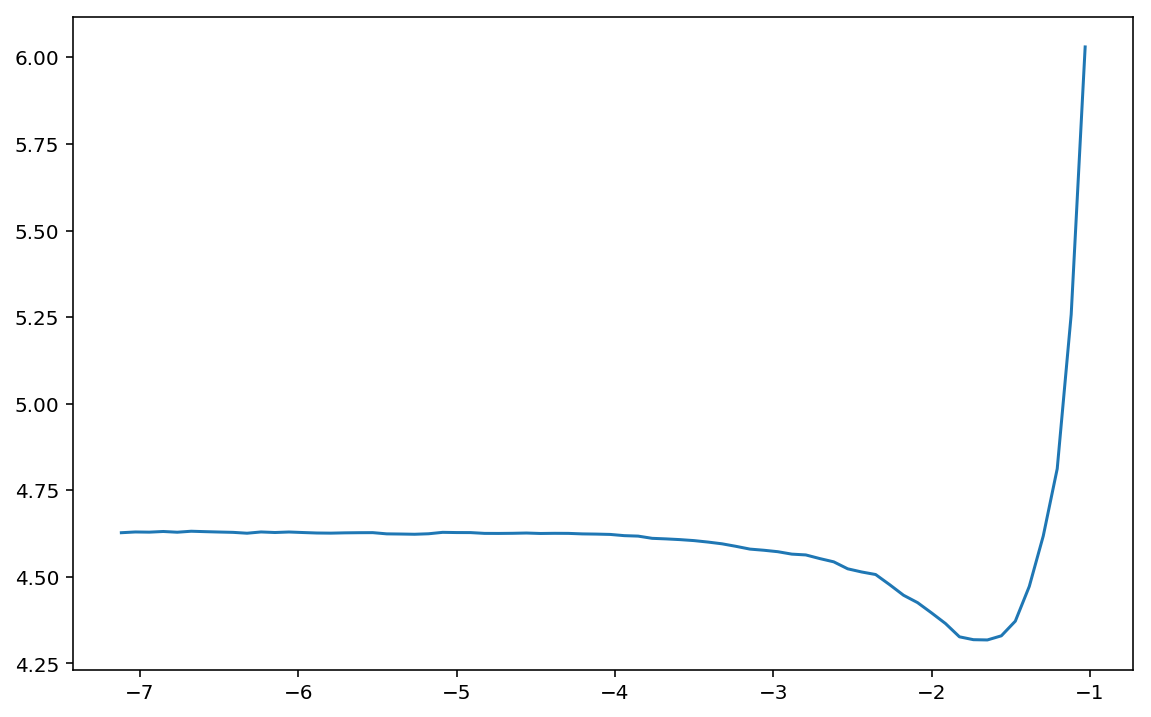

In [66]:
plt.rcParams['figure.figsize'] = [9.5, 6]

plt.plot(logs[10:-5],losses[10:-5])

### Learning Rate finder without weight parameter:
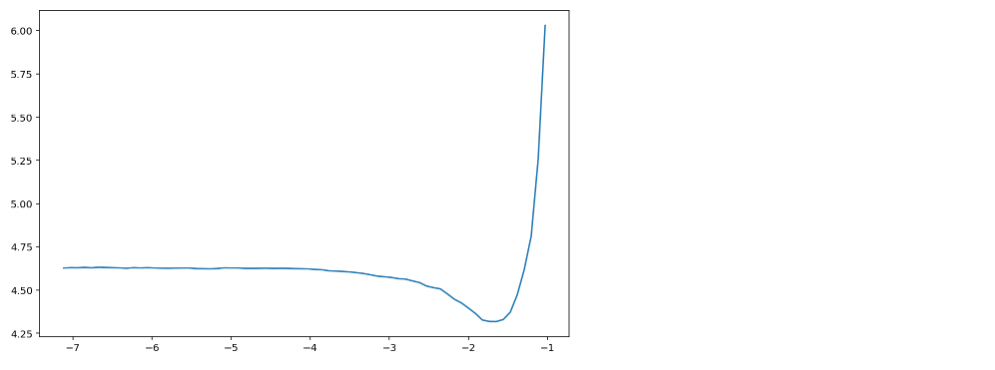

### Learning Rate finder with weight parameter:
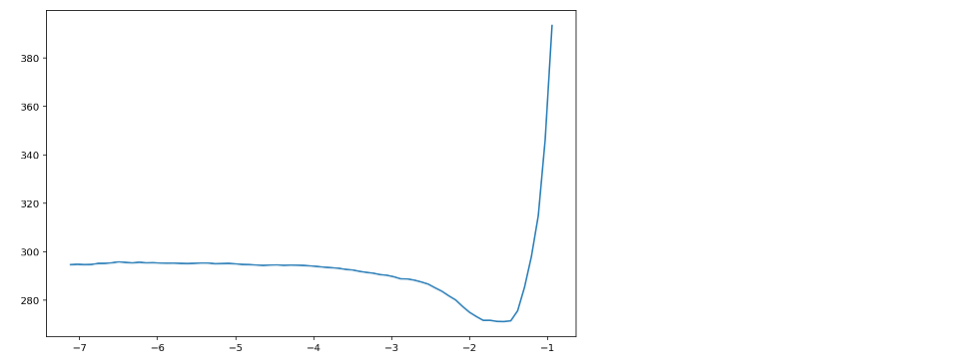

In [67]:
print("{:5f}".format(1e-2))
print("{:5f}".format(1e-3))
print("{:5f}".format(1e-4))

0.010000
0.001000
0.000100


## Train the model...

In [68]:
train_losses, valid_losses, val_acc_history, lr_hist = [], [], [], []

In [69]:
print(use_weights)

False


In [70]:
model = train_model(model, criterion, optimizer,
                    exp_lr_scheduler, 
                    use_scheduler=True, 
                    use_weights=use_weights, 
                    num_epochs=40,
                    first_epoch=0,
                    ufilename="wgt_augmnt",
                    is_inception=(model_name=="inception"))

Epoch 1/40
-----------
train Loss: 2.6280 Acc: 0.4887
valid Loss: 1.1767 Acc: 0.8044
Accuracy has increased (0.000000 --> 0.804401).  Saving model as resnet50_acc_augmnt1...
Validation loss decreased (inf --> 1.176701).  Saving model as resnet50_augmnt1...

Epoch 2/40
-----------
train Loss: 0.9455 Acc: 0.8300
valid Loss: 0.6932 Acc: 0.8667
Accuracy has increased (0.804401 --> 0.866748).  Saving model as resnet50_acc_augmnt2...
Validation loss decreased (1.176701 --> 0.693205).  Saving model as resnet50_augmnt2...

Epoch 3/40
-----------
train Loss: 0.6217 Acc: 0.8776
valid Loss: 0.5169 Acc: 0.8949
Accuracy has increased (0.866748 --> 0.894866).  Saving model as resnet50_acc_augmnt3...
Validation loss decreased (0.693205 --> 0.516912).  Saving model as resnet50_augmnt3...

Epoch 4/40
-----------
train Loss: 0.4636 Acc: 0.9080
valid Loss: 0.4536 Acc: 0.8985
Accuracy has increased (0.894866 --> 0.898533).  Saving model as resnet50_acc_augmnt4...
Validation loss decreased (0.516912 --> 0.

### Print train vs validation losses

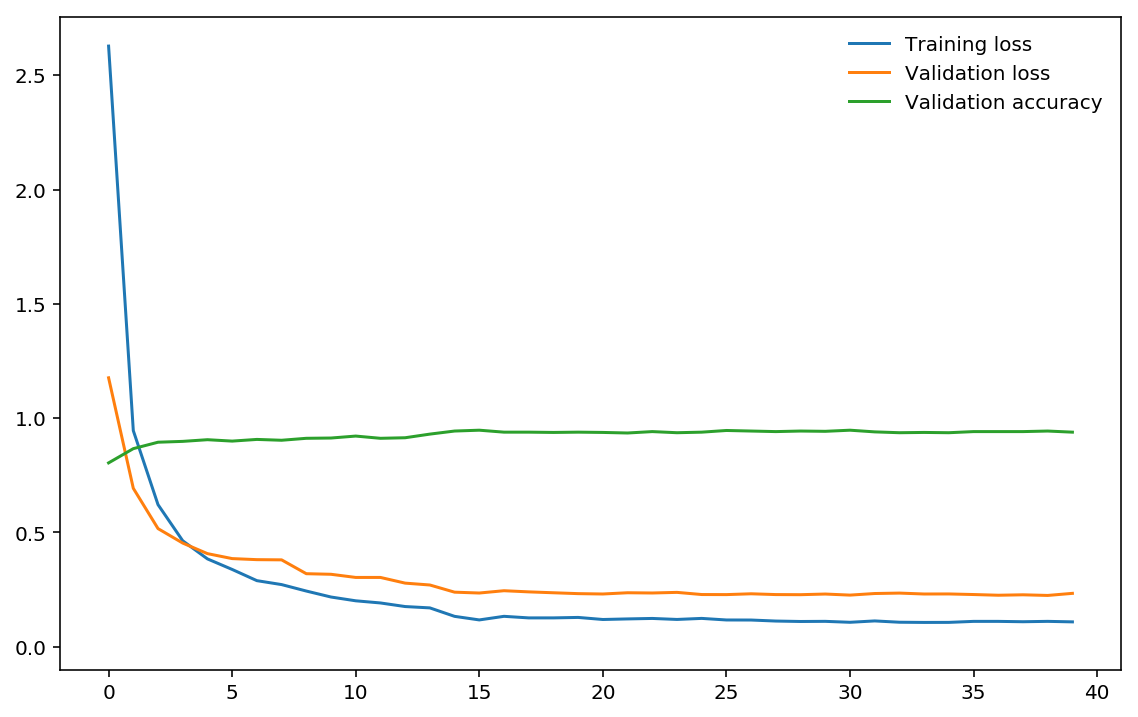

In [71]:
plt.rcParams['figure.figsize'] = [9.5, 6]

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.plot(val_acc_history, label="Validation accuracy")
plt.legend(frameon=False)
plt.ylim(ymin=-0.1) 
plt.show()

## Training without learning rate annealing
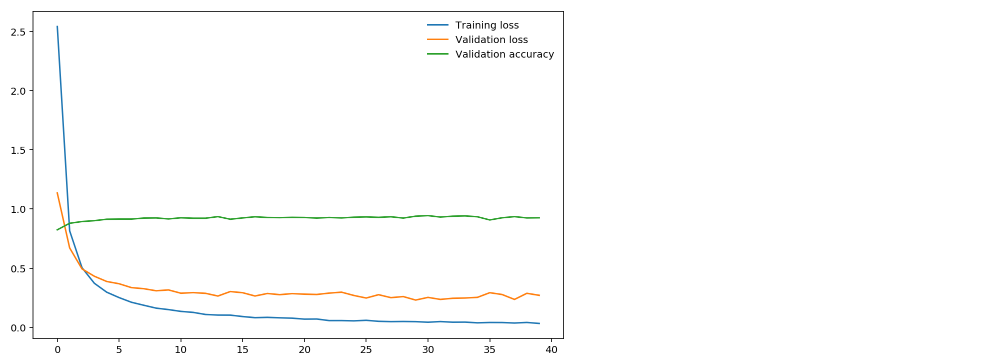

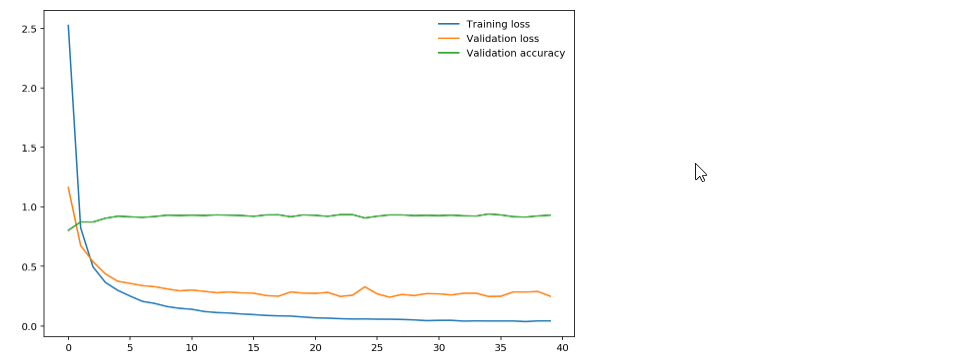

## Training with learning rate annealing

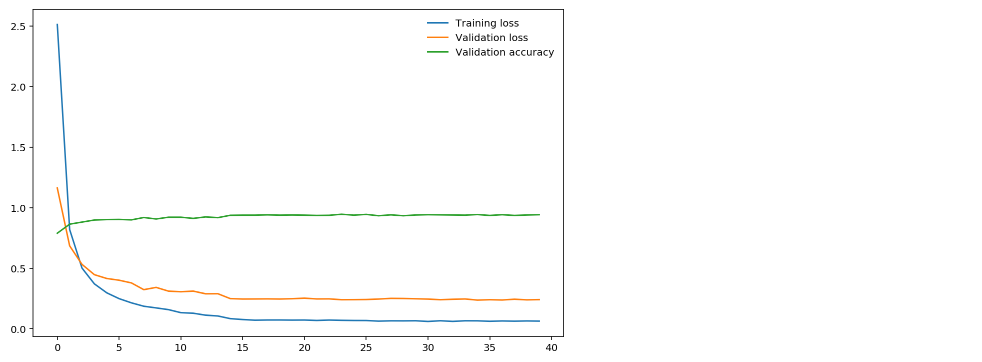

## Training with learning rate annealing and jitter augmentation
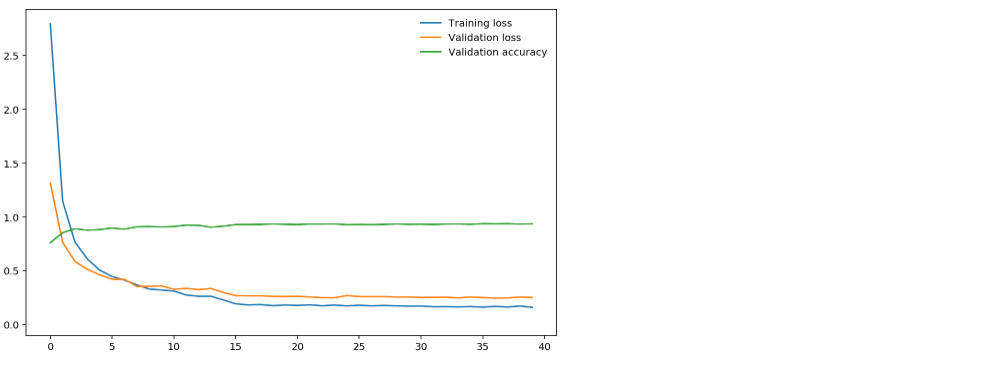

## Training with weights and no learning rate annealing
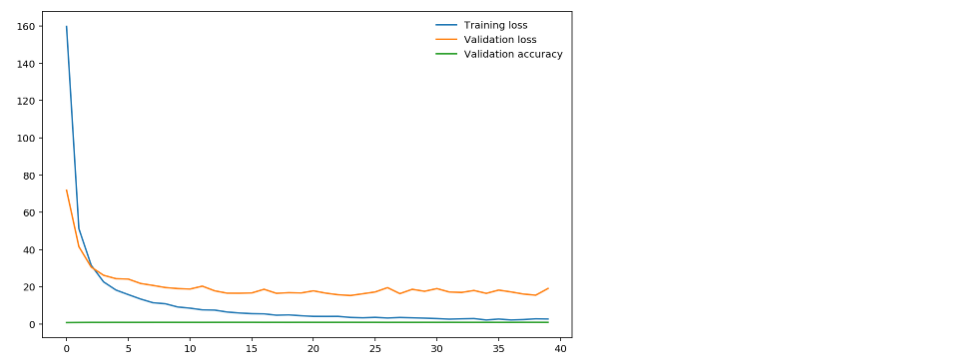

## Training with weights and jitter and lr annealing

### Corrected estimation of loss 

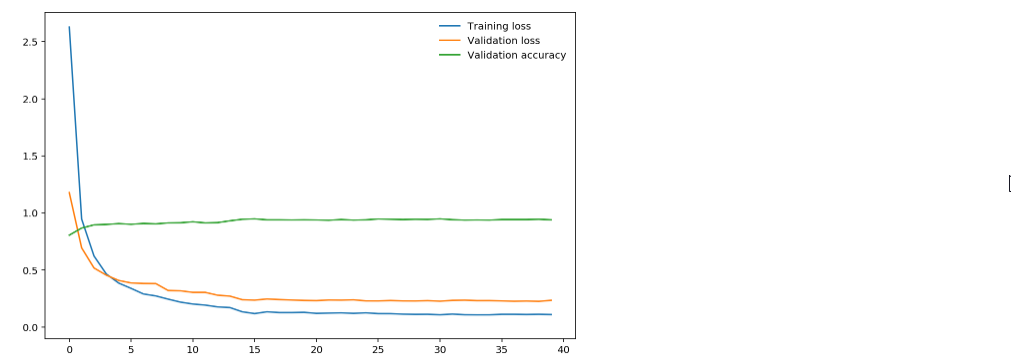

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [72]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0133,  0.0147, -0.0154,  ..., -0.0409, -0.0430, -0.0708],
                        [ 0.0041,  0.0058,  0.0149,  ...,  0.0022, -0.0209, -0.0385],
                        [ 0.0223,  0.0236,  0.0161,  ...,  0.1028,  0.0626,  0.0520],
                        ...,
                        [-0.0009,  0.0278, -0.0101,  ..., -0.1272, -0.0766,  0.0078],
                        [ 0.0036,  0.0480,  0.0621,  ...,  0.0243, -0.0337, -0.0157],
                        [-0.0800, -0.0322, -0.0178,  ...,  0.0354,  0.0224,  0.0017]],
              
                       [[-0.0185,  0.0114,  0.0239,  ...,  0.0537,  0.0440, -0.0095],
                        [-0.0077,  0.0189,  0.0680,  ...,  0.1596,  0.1461,  0.1200],
                        [-0.0460, -0.0761, -0.0896,  ...,  0.1211,  0.1670,  0.1762],
                        ...,
                        [ 0.0288,  0.0137, -0.0838,  ..., -0.3808, -0.3041, -0.1397],
                        [ 0.0829,  0

## Reset to best saved state dicts based on accuracy...

(This is what is pushed back to model at the end of training)

In [73]:
state_dict = torch.load('resnet50_acc_wgt_augmnt_16.pt')
opt_state_dict = torch.load('resnet50_acc_wgt_augmnt_16_optimizer.pt')

In [74]:
state_dict = torch.load('resnet50_wgt_augmnt_31.pt')
opt_state_dict = torch.load('resnet50_wgt_augmnt_31_optimizer.pt')

In [75]:
state_dict = torch.load('resnet50_acc_schd_aug_36.pt')
opt_state_dict = torch.load('resnet50_acc_schd_aug_36_optimizer.pt')

In [76]:
state_dict = torch.load('resnet50_acc_wgts_38.pt')
opt_state_dict = torch.load('resnet50_acc_wgts_38_optimizer.pt')

In [77]:
state_dict = torch.load('resnet50_acc_35.pt')
opt_state_dict = torch.load('resnet50_acc_35_optimizer.pt')

In [78]:
state_dict = torch.load('resnet50_30_nolrsched.pt')
opt_state_dict = torch.load('resnet50_30_optimizer_nolrsched.pt')

In [79]:
state_dict = torch.load('resnet50_acc_24.pt')
opt_state_dict = torch.load('resnet50_24_optimizer.pt')

In [80]:
state_dict = torch.load('resnet50_35.pt')
opt_state_dict = torch.load('resnet50_35_optimizer.pt')

In [81]:
state_dict = torch.load('resnet50_27.pt')
opt_state_dict = torch.load('resnet50_27_optimizer.pt')

## Reset to best saved state dicts based on loss or accuracy...

In [82]:
model.load_state_dict(state_dict)
optimizer.load_state_dict(opt_state_dict)

In [83]:
def compare_dicts(dict_1, dict_2):
    dicts_differ = 0
    for key_item_1, key_item_2 in zip(dict_1.items(), dict_2.items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            dicts_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
                
    if dicts_differ == 0:
        print('State_Dicts match perfectly! :)')

In [84]:
compare_dicts(model.state_dict(), state_dict)

State_Dicts match perfectly! :)


In [85]:
checkpt = 'resnet50_wgt_augmnt_16_epochs_model_and_opt.pth'

In [86]:
model.class_to_idx = image_datasets['train'].class_to_idx

In [87]:
best_epoch = 16

In [88]:
torch.save({'model_statedict':model.state_dict(),
            'optimizer_statedict':optimizer.state_dict(), 
            'class_to_idx' : model.class_to_idx,
            'best_epoch'   : best_epoch,
            'train_losses' : train_losses, 
            'valid_losses' : valid_losses, 
            'val_acc_history' : val_acc_history, 
            'lr_hist'      : lr_hist}, 
           checkpt)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [89]:
train_on_gpu

True

### Resnet50

In [90]:
state_dicts_name = 'resnet50_wgt_augmnt_16_epochs_model_and_opt.pth'

In [91]:
state_dicts_name = 'resnet50_wgt_augmnt_31_epochs_model_and_opt.pth'

In [92]:
state_dicts_name = 'resnet50_acc_36_epochs_aug_model_and_opt.pth'

In [93]:
state_dicts_name = 'resnet50_acc_38_epochs_wgts_model_and_opt.pth'

In [94]:
state_dicts_name = 'resnet50_acc_35_epochs_model_and_opt.pth'

In [95]:
state_dicts_name = 'resnet50_24_epochs_model_and_opt.pth'

In [96]:
state_dicts_name = 'resnet50_23_epochs_model_and_opt.pth'

In [97]:
state_dicts_name

'resnet50_24_epochs_model_and_opt.pth'

In [98]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
if train_on_gpu:
    state_dicts = torch.load(state_dicts_name)
else:
    state_dicts = torch.load(state_dicts_name, map_location='cpu')

#print(state_dict.keys())

In [99]:
state_dicts.keys()

dict_keys(['model_statedict', 'optimizer_statedict', 'class_to_idx'])

In [100]:
model.load_state_dict(state_dicts['model_statedict'])

In [101]:
optimizer.load_state_dict(state_dicts['optimizer_statedict'])

In [102]:
model.class_to_idx = state_dicts['class_to_idx']

In [103]:
best_epoch = 24

In [104]:
best_epoch = state_dicts['best_epoch']

In [105]:
len(state_dicts['lr_hist'])

In [106]:
lr_at_best = float(np.array(state_dicts['lr_hist'][state_dicts['best_epoch']-1]))

In [107]:
print("{:.7f}".format(lr_at_best))

0.0001000


In [108]:
lr = 0.00100

In [109]:
use_weights

False

In [110]:
train_losses = state_dicts['train_losses']
valid_losses = state_dicts['valid_losses']
val_acc_history = state_dicts['val_acc_history']
lr_hist = state_dicts['lr_hist']

## Evaluate model - method 1

In [111]:
# track test loss 
# over 102 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.to(device)
model.eval() # eval mode

with torch.no_grad():
    # iterate over test data
    for data, target in dataloaders['valid']:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)

        # update  test loss 
        test_loss += loss.item() * (1 if use_weights==True else data.size(0))
        
        # print(loss.item(), loss.item() * (1 if use_weights==True else data.size(0)), test_loss)
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # calculate test accuracy for each object class
        for i in range(batch_size):
            if target.data.size(0) > i:
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
                
# calculate avg test loss
test_loss = test_loss/len(dataloaders['valid'].dataset)                

In [112]:
accuracy_result = []

for i in range(102):
    if class_total[i] > 0:
        accuracy_result.append([idx_to_class[i], cat_to_name[idx_to_class[i]], 
                                np.sum(class_correct[i]), np.sum(class_total[i]),
                                100 * class_correct[i] / class_total[i]])
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

In [113]:
print(state_dicts_name)
print()
print('Report on Valid dataset')
print('-----------------------')
print('Test Loss: {:.6f}'.format(test_loss))
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)\n' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

sorted_accuracy = sorted(accuracy_result, key=lambda x: int(x[0]))
print('Accuracy per class: ')
for res in sorted_accuracy:
    print('{:<3} {:<30} {:>5}/{:<10} {:>10.2f}%'.format(res[0], res[1], res[2].astype(int), res[3].astype(int), res[4]))

resnet50_24_epochs_model_and_opt.pth

Report on Valid dataset
-----------------------
Test Loss: 0.236306

Test Accuracy (Overall): 94.25% (771/818)

Accuracy per class: 
1   pink primrose                      7/8               87.50%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        0/1                0.00%
8   bird of paradise                   5/5              100.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         7/10              70.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.0

## Best results with weights and jitter and lr annealing (16 epochs):
```
Report on Valid dataset
-----------------------
Test Loss: 0.235062

Test Accuracy (Overall): 94.74% (775/818)

Accuracy per class: 
1   pink primrose                      8/8              100.00%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          3/6               50.00%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        1/1              100.00%
8   bird of paradise                   5/5              100.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         8/10              80.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              7/7              100.00%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         2/3               66.67%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                     10/10             100.00%
31  carnation                          1/2               50.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   6/7               85.71%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               5/6               83.33%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         2/3               66.67%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    16/16             100.00%
42  daffodil                           6/6              100.00%
43  sword lily                        14/14             100.00%
44  poinsettia                         7/9               77.78%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        16/18              88.89%
47  marigold                           3/3              100.00%
48  buttercup                          8/9               88.89%
49  oxeye daisy                        8/8              100.00%
50  common dandelion                  11/11             100.00%
51  petunia                           26/28              92.86%
52  wild pansy                        10/10             100.00%
53  primula                            5/9               55.56%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       6/6              100.00%
67  spring crocus                      2/2              100.00%
68  bearded iris                       8/8              100.00%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             7/8               87.50%
73  water lily                        19/19             100.00%
74  rose                              15/15             100.00%
75  thorn apple                       10/12              83.33%
76  morning glory                     19/20              95.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          4/4              100.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          12/13              92.31%
83  hibiscus                          12/13              92.31%
84  columbine                          9/10              90.00%
85  desert-rose                        4/5               80.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          22/25              88.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        7/9               77.78%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     13/13             100.00%
96  camellia                           7/10              70.00%
97  mallow                             5/7               71.43%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    5/5              100.00%
102 blackberry lily                    6/6              100.00%
```

## Best results with weights and jitter and lr annealing (31 epochs):
```
Report on Valid dataset
-----------------------
Test Loss: 14.142049

Test Accuracy (Overall): 94.74% (775/818)

Accuracy per class: 
1   pink primrose                      8/8              100.00%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          3/6               50.00%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        0/1                0.00%
8   bird of paradise                   5/5              100.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         8/10              80.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              7/7              100.00%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         3/3              100.00%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                     10/10             100.00%
31  carnation                          1/2               50.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   6/7               85.71%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               5/6               83.33%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         2/3               66.67%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    16/16             100.00%
42  daffodil                           6/6              100.00%
43  sword lily                        14/14             100.00%
44  poinsettia                         7/9               77.78%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        15/18              83.33%
47  marigold                           3/3              100.00%
48  buttercup                          9/9              100.00%
49  oxeye daisy                        8/8              100.00%
50  common dandelion                  11/11             100.00%
51  petunia                           26/28              92.86%
52  wild pansy                        10/10             100.00%
53  primula                            7/9               77.78%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       6/6              100.00%
67  spring crocus                      2/2              100.00%
68  bearded iris                       7/8               87.50%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             7/8               87.50%
73  water lily                        19/19             100.00%
74  rose                              14/15              93.33%
75  thorn apple                       10/12              83.33%
76  morning glory                     19/20              95.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          4/4              100.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          13/13             100.00%
83  hibiscus                          12/13              92.31%
84  columbine                          9/10              90.00%
85  desert-rose                        4/5               80.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          22/25              88.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        7/9               77.78%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     12/13              92.31%
96  camellia                           7/10              70.00%
97  mallow                             5/7               71.43%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    5/5              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best results with jitter and data augmentation and lr annealing:
```
Report on Valid dataset
-----------------------
Test Loss: 0.251537

Test Accuracy (Overall): 93.77% (767/818)

Accuracy per class: 
1   pink primrose                      8/8              100.00%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          3/6               50.00%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        1/1              100.00%
8   bird of paradise                   5/5              100.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         8/10              80.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              7/7              100.00%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         3/3              100.00%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                      7/10              70.00%
31  carnation                          0/2                0.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   6/7               85.71%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               4/6               66.67%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         2/3               66.67%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    14/16              87.50%
42  daffodil                           6/6              100.00%
43  sword lily                        14/14             100.00%
44  poinsettia                         7/9               77.78%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        14/18              77.78%
47  marigold                           3/3              100.00%
48  buttercup                          7/9               77.78%
49  oxeye daisy                        8/8              100.00%
50  common dandelion                  11/11             100.00%
51  petunia                           26/28              92.86%
52  wild pansy                        10/10             100.00%
53  primula                            7/9               77.78%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       6/6              100.00%
67  spring crocus                      2/2              100.00%
68  bearded iris                       7/8               87.50%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             8/8              100.00%
73  water lily                        19/19             100.00%
74  rose                              14/15              93.33%
75  thorn apple                       10/12              83.33%
76  morning glory                     18/20              90.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          4/4              100.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          12/13              92.31%
83  hibiscus                          12/13              92.31%
84  columbine                          9/10              90.00%
85  desert-rose                        5/5              100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          22/25              88.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        7/9               77.78%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     13/13             100.00%
96  camellia                           8/10              80.00%
97  mallow                             5/7               71.43%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    4/5               80.00%
102 blackberry lily                    6/6              100.00%
```

### Best result with weights and no lr annealing:
```
Report on Valid dataset
-----------------------
Test Loss: 15.870560

Test Accuracy (Overall): 93.89% (768/818)

Accuracy per class: 
1   pink primrose                      7/8               87.50%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   1/2               50.00%
4   sweet pea                          3/6               50.00%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        1/1              100.00%
8   bird of paradise                   4/5               80.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         5/10              50.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              6/7               85.71%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         3/3              100.00%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                     10/10             100.00%
31  carnation                          1/2               50.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   5/7               71.43%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               5/6               83.33%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         2/3               66.67%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    15/16              93.75%
42  daffodil                           5/6               83.33%
43  sword lily                        13/14              92.86%
44  poinsettia                         7/9               77.78%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        16/18              88.89%
47  marigold                           3/3              100.00%
48  buttercup                          9/9              100.00%
49  oxeye daisy                        7/8               87.50%
50  common dandelion                  11/11             100.00%
51  petunia                           26/28              92.86%
52  wild pansy                        10/10             100.00%
53  primula                            8/9               88.89%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       6/6              100.00%
67  spring crocus                      2/2              100.00%
68  bearded iris                       8/8              100.00%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             7/8               87.50%
73  water lily                        19/19             100.00%
74  rose                              14/15              93.33%
75  thorn apple                       11/12              91.67%
76  morning glory                     16/20              80.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          4/4              100.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          13/13             100.00%
83  hibiscus                          11/13              84.62%
84  columbine                          7/10              70.00%
85  desert-rose                        5/5              100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          24/25              96.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        8/9               88.89%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     12/13              92.31%
96  camellia                           8/10              80.00%
97  mallow                             6/7               85.71%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    5/5              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best result before lr annealing:
```
Test Loss: 0.253205

Test Accuracy (Overall): 94.38% (772/818)

Accuracy per class: 
1   pink primrose                      8/8              100.00%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          3/6               50.00%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        0/1                0.00%
8   bird of paradise                   4/5               80.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         6/10              60.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              7/7              100.00%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         2/3               66.67%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                     10/10             100.00%
31  carnation                          0/2                0.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   6/7               85.71%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               4/6               66.67%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         1/3               33.33%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    16/16             100.00%
42  daffodil                           6/6              100.00%
43  sword lily                        14/14             100.00%
44  poinsettia                         8/9               88.89%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        16/18              88.89%
47  marigold                           3/3              100.00%
48  buttercup                          9/9              100.00%
49  oxeye daisy                        7/8               87.50%
50  common dandelion                  11/11             100.00%
51  petunia                           24/28              85.71%
52  wild pansy                        10/10             100.00%
53  primula                            8/9               88.89%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       5/6               83.33%
67  spring crocus                      2/2              100.00%
68  bearded iris                       8/8              100.00%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             7/8               87.50%
73  water lily                        19/19             100.00%
74  rose                              14/15              93.33%
75  thorn apple                       12/12             100.00%
76  morning glory                     19/20              95.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          3/4               75.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          13/13             100.00%
83  hibiscus                          11/13              84.62%
84  columbine                          8/10              80.00%
85  desert-rose                        5/5              100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           5/6               83.33%
88  cyclamen                          24/25              96.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        8/9               88.89%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     13/13             100.00%
96  camellia                          10/10             100.00%
97  mallow                             3/7               42.86%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    5/5              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best result after learning rate annealing:
```
Test Loss: 0.236306

Test Accuracy (Overall): 94.25% (771/818)

Accuracy per class: 
1   pink primrose                      7/8               87.50%
2   hard-leaved pocket orchid          6/6              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   7/7              100.00%
6   tiger lily                         1/1              100.00%
7   moon orchid                        0/1                0.00%
8   bird of paradise                   5/5              100.00%
9   monkshood                          3/3              100.00%
10  globe thistle                      4/4              100.00%
11  snapdragon                         7/10              70.00%
12  colt's foot                        5/5              100.00%
13  king protea                        5/5              100.00%
14  spear thistle                      1/1              100.00%
15  yellow iris                        7/7              100.00%
16  globe-flower                       2/2              100.00%
17  purple coneflower                 16/16             100.00%
18  peruvian lily                     11/11             100.00%
19  balloon flower                     4/4              100.00%
20  giant white arum lily              6/7               85.71%
21  fire lily                          4/4              100.00%
22  pincushion flower                  8/8              100.00%
23  fritillary                        12/12             100.00%
24  red ginger                         5/5              100.00%
25  grape hyacinth                     2/2              100.00%
26  corn poppy                         2/3               66.67%
27  prince of wales feathers           1/1              100.00%
28  stemless gentian                   5/5              100.00%
29  artichoke                          7/7              100.00%
30  sweet william                     10/10             100.00%
31  carnation                          1/2               50.00%
32  garden phlox                       3/3              100.00%
33  love in the mist                   6/7               85.71%
34  mexican aster                      7/7              100.00%
35  alpine sea holly                   3/4               75.00%
36  ruby-lipped cattleya               4/6               66.67%
37  cape flower                        8/8              100.00%
38  great masterwort                   4/4              100.00%
39  siam tulip                         1/3               33.33%
40  lenten rose                        5/5              100.00%
41  barbeton daisy                    14/16              87.50%
42  daffodil                           6/6              100.00%
43  sword lily                        14/14             100.00%
44  poinsettia                         8/9               88.89%
45  bolero deep blue                   4/4              100.00%
46  wallflower                        16/18              88.89%
47  marigold                           3/3              100.00%
48  buttercup                          9/9              100.00%
49  oxeye daisy                        7/8               87.50%
50  common dandelion                  11/11             100.00%
51  petunia                           25/28              89.29%
52  wild pansy                         9/10              90.00%
53  primula                            8/9               88.89%
54  sunflower                         10/10             100.00%
55  pelargonium                        8/8              100.00%
56  bishop of llandaff                 9/9              100.00%
57  gaura                              6/6              100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      4/4              100.00%
60  pink-yellow dahlia                14/14             100.00%
61  cautleya spicata                   6/6              100.00%
62  japanese anemone                   2/3               66.67%
63  black-eyed susan                   8/8              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       6/6              100.00%
67  spring crocus                      2/2              100.00%
68  bearded iris                       7/8               87.50%
69  windflower                         5/5              100.00%
70  tree poppy                         7/7              100.00%
71  gazania                            5/5              100.00%
72  azalea                             7/8               87.50%
73  water lily                        19/19             100.00%
74  rose                              15/15             100.00%
75  thorn apple                       10/12              83.33%
76  morning glory                     19/20              95.00%
77  passion flower                    21/21             100.00%
78  lotus lotus                       11/11             100.00%
79  toad lily                          4/4              100.00%
80  anthurium                         12/12             100.00%
81  frangipani                        18/18             100.00%
82  clematis                          13/13             100.00%
83  hibiscus                          12/13              92.31%
84  columbine                          9/10              90.00%
85  desert-rose                        5/5              100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           5/6               83.33%
88  cyclamen                          23/25              92.00%
89  watercress                        16/16             100.00%
90  canna lily                         2/2              100.00%
91  hippeastrum                        6/9               66.67%
92  bee balm                           2/2              100.00%
93  ball moss                          5/6               83.33%
94  foxglove                          13/14              92.86%
95  bougainvillea                     13/13             100.00%
96  camellia                           8/10              80.00%
97  mallow                             5/7               71.43%
98  mexican petunia                   10/10             100.00%
99  bromelia                           6/6              100.00%
100 blanket flower                     6/6              100.00%
101 trumpet creeper                    5/5              100.00%
102 blackberry lily                    6/6              100.00%
```

### Also try test data...

In [114]:
# track test loss 
# over 102 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.to(device)
model.eval() # eval mode

with torch.no_grad():
    # iterate over test data
    for data, target in dataloaders['test']:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)
        
        # update  test loss 
        test_loss += loss.item() * (1 if use_weights==True else data.size(0))
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # calculate test accuracy for each object class
        for i in range(batch_size):
            if target.data.size(0) > i:
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(dataloaders['test'].dataset)

In [115]:
accuracy_test_result = []

for i in range(102):
    if class_total[i] > 0:
        accuracy_test_result.append([idx_to_class[i], cat_to_name[idx_to_class[i]], 
                                np.sum(class_correct[i]), np.sum(class_total[i]),
                                100 * class_correct[i] / class_total[i]])
    else:
        print('Test Accuracy of %5s: N/A (no test examples)' % (classes[i]))

In [116]:
print(state_dicts_name)
print()
print('Report on Test dataset')
print('----------------------')
print('Test Loss: {:.6f}'.format(test_loss))
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)\n' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

sorted_test_accuracy = sorted(accuracy_test_result, key=lambda x: int(x[0]))
print('Accuracy per class: ')
for res in sorted_test_accuracy:
    print('{:<3} {:<30} {:>5}/{:<10} {:>10.2f}%'.format(res[0], res[1], res[2].astype(int), res[3].astype(int), res[4]))

resnet50_24_epochs_model_and_opt.pth

Report on Test dataset
----------------------
Test Loss: 0.248105

Test Accuracy (Overall): 93.53% (766/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   4/4              100.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         6/9               66.67%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%

## Best results with weights and jitter and lr annealing (16 epochs)

### Worse than 31 epochs by 1, worse than best standard approach by 5...

```
Report on Test dataset
----------------------
Test Loss: 0.244877

Test Accuracy (Overall): 92.92% (761/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   3/4               75.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         8/9               88.89%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%
14  spear thistle                      3/3              100.00%
15  yellow iris                        4/4              100.00%
16  globe-flower                       3/3              100.00%
17  purple coneflower                  9/9              100.00%
18  peruvian lily                      6/6              100.00%
19  balloon flower                     7/7              100.00%
20  giant white arum lily              3/3              100.00%
21  fire lily                          2/2              100.00%
22  pincushion flower                  4/4              100.00%
23  fritillary                         7/7              100.00%
24  red ginger                         2/2              100.00%
25  grape hyacinth                     4/5               80.00%
26  corn poppy                         4/5               80.00%
27  prince of wales feathers           3/3              100.00%
28  stemless gentian                   6/6              100.00%
29  artichoke                          9/9              100.00%
30  sweet william                     13/14              92.86%
31  carnation                          2/2              100.00%
32  garden phlox                       4/6               66.67%
33  love in the mist                   7/8               87.50%
34  mexican aster                      5/5              100.00%
35  alpine sea holly                   6/6              100.00%
36  ruby-lipped cattleya               6/7               85.71%
37  cape flower                        8/8              100.00%
38  great masterwort                   8/8              100.00%
39  siam tulip                         4/5               80.00%
40  lenten rose                        7/8               87.50%
41  barbeton daisy                    14/14             100.00%
42  daffodil                           4/4              100.00%
43  sword lily                        15/16              93.75%
44  poinsettia                        10/11              90.91%
45  bolero deep blue                   3/3              100.00%
46  wallflower                        21/21             100.00%
47  marigold                           3/3              100.00%
48  buttercup                          5/5              100.00%
49  oxeye daisy                        2/3               66.67%
50  common dandelion                   8/8              100.00%
51  petunia                           20/24              83.33%
52  wild pansy                         8/8              100.00%
53  primula                            9/14              64.29%
54  sunflower                          3/4               75.00%
55  pelargonium                        7/7              100.00%
56  bishop of llandaff                 8/8              100.00%
57  gaura                             10/11              90.91%
58  geranium                          14/14             100.00%
59  orange dahlia                      7/7              100.00%
60  pink-yellow dahlia                10/10             100.00%
61  cautleya spicata                   8/8              100.00%
62  japanese anemone                   4/4              100.00%
63  black-eyed susan                   4/4              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       4/4              100.00%
67  spring crocus                      3/4               75.00%
68  bearded iris                       2/3               66.67%
69  windflower                         2/3               66.67%
70  tree poppy                         4/4              100.00%
71  gazania                            9/9              100.00%
72  azalea                            11/11             100.00%
73  water lily                        26/28              92.86%
74  rose                              11/14              78.57%
75  thorn apple                       13/13             100.00%
76  morning glory                      4/4              100.00%
77  passion flower                    25/25             100.00%
78  lotus lotus                       14/14             100.00%
79  toad lily                          3/3              100.00%
80  anthurium                         11/11             100.00%
81  frangipani                        13/13             100.00%
82  clematis                          15/17              88.24%
83  hibiscus                          11/14              78.57%
84  columbine                         10/10             100.00%
85  desert-rose                       10/10             100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          12/13              92.31%
89  watercress                        14/15              93.33%
90  canna lily                        13/14              92.86%
91  hippeastrum                        6/8               75.00%
92  bee balm                          10/11              90.91%
93  ball moss                          6/6              100.00%
94  foxglove                          15/16              93.75%
95  bougainvillea                     13/14              92.86%
96  camellia                           6/9               66.67%
97  mallow                             3/5               60.00%
98  mexican petunia                    3/4               75.00%
99  bromelia                           7/7              100.00%
100 blanket flower                     8/8              100.00%
101 trumpet creeper                    4/4              100.00%
102 blackberry lily                    6/6              100.00%
```

## Best result with weights and jitter and lr annealing (31 epochs)

### It is actually worse on the test data!

```
Report on Test dataset
----------------------
Test Loss: 14.496706

Test Accuracy (Overall): 93.04% (762/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   4/4              100.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         8/9               88.89%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%
14  spear thistle                      3/3              100.00%
15  yellow iris                        4/4              100.00%
16  globe-flower                       2/3               66.67%
17  purple coneflower                  9/9              100.00%
18  peruvian lily                      6/6              100.00%
19  balloon flower                     7/7              100.00%
20  giant white arum lily              3/3              100.00%
21  fire lily                          2/2              100.00%
22  pincushion flower                  4/4              100.00%
23  fritillary                         7/7              100.00%
24  red ginger                         2/2              100.00%
25  grape hyacinth                     4/5               80.00%
26  corn poppy                         4/5               80.00%
27  prince of wales feathers           3/3              100.00%
28  stemless gentian                   6/6              100.00%
29  artichoke                          9/9              100.00%
30  sweet william                     13/14              92.86%
31  carnation                          2/2              100.00%
32  garden phlox                       3/6               50.00%
33  love in the mist                   7/8               87.50%
34  mexican aster                      5/5              100.00%
35  alpine sea holly                   6/6              100.00%
36  ruby-lipped cattleya               6/7               85.71%
37  cape flower                        8/8              100.00%
38  great masterwort                   8/8              100.00%
39  siam tulip                         4/5               80.00%
40  lenten rose                        7/8               87.50%
41  barbeton daisy                    14/14             100.00%
42  daffodil                           4/4              100.00%
43  sword lily                        16/16             100.00%
44  poinsettia                        10/11              90.91%
45  bolero deep blue                   3/3              100.00%
46  wallflower                        20/21              95.24%
47  marigold                           3/3              100.00%
48  buttercup                          5/5              100.00%
49  oxeye daisy                        3/3              100.00%
50  common dandelion                   8/8              100.00%
51  petunia                           22/24              91.67%
52  wild pansy                         8/8              100.00%
53  primula                           11/14              78.57%
54  sunflower                          3/4               75.00%
55  pelargonium                        7/7              100.00%
56  bishop of llandaff                 8/8              100.00%
57  gaura                             10/11              90.91%
58  geranium                          14/14             100.00%
59  orange dahlia                      7/7              100.00%
60  pink-yellow dahlia                10/10             100.00%
61  cautleya spicata                   8/8              100.00%
62  japanese anemone                   3/4               75.00%
63  black-eyed susan                   4/4              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       4/4              100.00%
67  spring crocus                      3/4               75.00%
68  bearded iris                       2/3               66.67%
69  windflower                         2/3               66.67%
70  tree poppy                         4/4              100.00%
71  gazania                            9/9              100.00%
72  azalea                            11/11             100.00%
73  water lily                        26/28              92.86%
74  rose                              12/14              85.71%
75  thorn apple                       13/13             100.00%
76  morning glory                      4/4              100.00%
77  passion flower                    25/25             100.00%
78  lotus lotus                       14/14             100.00%
79  toad lily                          3/3              100.00%
80  anthurium                         11/11             100.00%
81  frangipani                        13/13             100.00%
82  clematis                          15/17              88.24%
83  hibiscus                          12/14              85.71%
84  columbine                          9/10              90.00%
85  desert-rose                        9/10              90.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          12/13              92.31%
89  watercress                        14/15              93.33%
90  canna lily                        10/14              71.43%
91  hippeastrum                        6/8               75.00%
92  bee balm                          11/11             100.00%
93  ball moss                          6/6              100.00%
94  foxglove                          15/16              93.75%
95  bougainvillea                     13/14              92.86%
96  camellia                           5/9               55.56%
97  mallow                             4/5               80.00%
98  mexican petunia                    3/4               75.00%
99  bromelia                           7/7              100.00%
100 blanket flower                     8/8              100.00%
101 trumpet creeper                    4/4              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best result with jitter augmentation and lr annealing
```
Report on Test dataset
----------------------
Test Loss: 0.248105

Test Accuracy (Overall): 93.53% (766/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   4/4              100.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         6/9               66.67%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%
14  spear thistle                      3/3              100.00%
15  yellow iris                        4/4              100.00%
16  globe-flower                       1/3               33.33%
17  purple coneflower                  9/9              100.00%
18  peruvian lily                      6/6              100.00%
19  balloon flower                     7/7              100.00%
20  giant white arum lily              3/3              100.00%
21  fire lily                          2/2              100.00%
22  pincushion flower                  4/4              100.00%
23  fritillary                         7/7              100.00%
24  red ginger                         2/2              100.00%
25  grape hyacinth                     4/5               80.00%
26  corn poppy                         4/5               80.00%
27  prince of wales feathers           3/3              100.00%
28  stemless gentian                   6/6              100.00%
29  artichoke                          9/9              100.00%
30  sweet william                     13/14              92.86%
31  carnation                          2/2              100.00%
32  garden phlox                       3/6               50.00%
33  love in the mist                   6/8               75.00%
34  mexican aster                      5/5              100.00%
35  alpine sea holly                   6/6              100.00%
36  ruby-lipped cattleya               6/7               85.71%
37  cape flower                        8/8              100.00%
38  great masterwort                   8/8              100.00%
39  siam tulip                         4/5               80.00%
40  lenten rose                        7/8               87.50%
41  barbeton daisy                    14/14             100.00%
42  daffodil                           4/4              100.00%
43  sword lily                        16/16             100.00%
44  poinsettia                        10/11              90.91%
45  bolero deep blue                   3/3              100.00%
46  wallflower                        20/21              95.24%
47  marigold                           3/3              100.00%
48  buttercup                          5/5              100.00%
49  oxeye daisy                        2/3               66.67%
50  common dandelion                   8/8              100.00%
51  petunia                           22/24              91.67%
52  wild pansy                         8/8              100.00%
53  primula                           13/14              92.86%
54  sunflower                          4/4              100.00%
55  pelargonium                        7/7              100.00%
56  bishop of llandaff                 8/8              100.00%
57  gaura                             11/11             100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      7/7              100.00%
60  pink-yellow dahlia                10/10             100.00%
61  cautleya spicata                   8/8              100.00%
62  japanese anemone                   4/4              100.00%
63  black-eyed susan                   4/4              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       4/4              100.00%
67  spring crocus                      3/4               75.00%
68  bearded iris                       2/3               66.67%
69  windflower                         2/3               66.67%
70  tree poppy                         4/4              100.00%
71  gazania                            9/9              100.00%
72  azalea                            11/11             100.00%
73  water lily                        27/28              96.43%
74  rose                              11/14              78.57%
75  thorn apple                       13/13             100.00%
76  morning glory                      4/4              100.00%
77  passion flower                    25/25             100.00%
78  lotus lotus                       14/14             100.00%
79  toad lily                          3/3              100.00%
80  anthurium                         11/11             100.00%
81  frangipani                        13/13             100.00%
82  clematis                          16/17              94.12%
83  hibiscus                          11/14              78.57%
84  columbine                          8/10              80.00%
85  desert-rose                       10/10             100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          12/13              92.31%
89  watercress                        15/15             100.00%
90  canna lily                        13/14              92.86%
91  hippeastrum                        6/8               75.00%
92  bee balm                          10/11              90.91%
93  ball moss                          6/6              100.00%
94  foxglove                          15/16              93.75%
95  bougainvillea                     13/14              92.86%
96  camellia                           6/9               66.67%
97  mallow                             4/5               80.00%
98  mexican petunia                    3/4               75.00%
99  bromelia                           7/7              100.00%
100 blanket flower                     8/8              100.00%
101 trumpet creeper                    4/4              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best result with weights and no lr annealing
```
Report on Test dataset
----------------------
Test Loss: 15.273549

Test Accuracy (Overall): 93.53% (766/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   4/4              100.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         6/9               66.67%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%
14  spear thistle                      3/3              100.00%
15  yellow iris                        4/4              100.00%
16  globe-flower                       1/3               33.33%
17  purple coneflower                  9/9              100.00%
18  peruvian lily                      6/6              100.00%
19  balloon flower                     7/7              100.00%
20  giant white arum lily              3/3              100.00%
21  fire lily                          2/2              100.00%
22  pincushion flower                  4/4              100.00%
23  fritillary                         7/7              100.00%
24  red ginger                         2/2              100.00%
25  grape hyacinth                     4/5               80.00%
26  corn poppy                         4/5               80.00%
27  prince of wales feathers           3/3              100.00%
28  stemless gentian                   6/6              100.00%
29  artichoke                          9/9              100.00%
30  sweet william                     13/14              92.86%
31  carnation                          2/2              100.00%
32  garden phlox                       3/6               50.00%
33  love in the mist                   6/8               75.00%
34  mexican aster                      5/5              100.00%
35  alpine sea holly                   6/6              100.00%
36  ruby-lipped cattleya               6/7               85.71%
37  cape flower                        8/8              100.00%
38  great masterwort                   8/8              100.00%
39  siam tulip                         4/5               80.00%
40  lenten rose                        7/8               87.50%
41  barbeton daisy                    14/14             100.00%
42  daffodil                           4/4              100.00%
43  sword lily                        16/16             100.00%
44  poinsettia                        10/11              90.91%
45  bolero deep blue                   3/3              100.00%
46  wallflower                        20/21              95.24%
47  marigold                           3/3              100.00%
48  buttercup                          5/5              100.00%
49  oxeye daisy                        2/3               66.67%
50  common dandelion                   8/8              100.00%
51  petunia                           22/24              91.67%
52  wild pansy                         8/8              100.00%
53  primula                           13/14              92.86%
54  sunflower                          4/4              100.00%
55  pelargonium                        7/7              100.00%
56  bishop of llandaff                 8/8              100.00%
57  gaura                             11/11             100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      7/7              100.00%
60  pink-yellow dahlia                10/10             100.00%
61  cautleya spicata                   8/8              100.00%
62  japanese anemone                   4/4              100.00%
63  black-eyed susan                   4/4              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       4/4              100.00%
67  spring crocus                      3/4               75.00%
68  bearded iris                       2/3               66.67%
69  windflower                         2/3               66.67%
70  tree poppy                         4/4              100.00%
71  gazania                            9/9              100.00%
72  azalea                            11/11             100.00%
73  water lily                        27/28              96.43%
74  rose                              11/14              78.57%
75  thorn apple                       13/13             100.00%
76  morning glory                      4/4              100.00%
77  passion flower                    25/25             100.00%
78  lotus lotus                       14/14             100.00%
79  toad lily                          3/3              100.00%
80  anthurium                         11/11             100.00%
81  frangipani                        13/13             100.00%
82  clematis                          16/17              94.12%
83  hibiscus                          11/14              78.57%
84  columbine                          8/10              80.00%
85  desert-rose                       10/10             100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          12/13              92.31%
89  watercress                        15/15             100.00%
90  canna lily                        13/14              92.86%
91  hippeastrum                        6/8               75.00%
92  bee balm                          10/11              90.91%
93  ball moss                          6/6              100.00%
94  foxglove                          15/16              93.75%
95  bougainvillea                     13/14              92.86%
96  camellia                           6/9               66.67%
97  mallow                             4/5               80.00%
98  mexican petunia                    3/4               75.00%
99  bromelia                           7/7              100.00%
100 blanket flower                     8/8              100.00%
101 trumpet creeper                    4/4              100.00%
102 blackberry lily                    6/6              100.00%
```

### Best result with lr annealing
```
Report on Test dataset
----------------------
Test Loss: 0.248105

Test Accuracy (Overall): 93.53% (766/819)

Accuracy per class: 
1   pink primrose                      4/5               80.00%
2   hard-leaved pocket orchid          5/5              100.00%
3   canterbury bells                   2/2              100.00%
4   sweet pea                          4/6               66.67%
5   english marigold                   4/4              100.00%
6   tiger lily                         8/9               88.89%
7   moon orchid                        5/6               83.33%
8   bird of paradise                  10/10             100.00%
9   monkshood                          2/2              100.00%
10  globe thistle                      3/3              100.00%
11  snapdragon                         6/9               66.67%
12  colt's foot                        8/9               88.89%
13  king protea                        6/6              100.00%
14  spear thistle                      3/3              100.00%
15  yellow iris                        4/4              100.00%
16  globe-flower                       1/3               33.33%
17  purple coneflower                  9/9              100.00%
18  peruvian lily                      6/6              100.00%
19  balloon flower                     7/7              100.00%
20  giant white arum lily              3/3              100.00%
21  fire lily                          2/2              100.00%
22  pincushion flower                  4/4              100.00%
23  fritillary                         7/7              100.00%
24  red ginger                         2/2              100.00%
25  grape hyacinth                     4/5               80.00%
26  corn poppy                         4/5               80.00%
27  prince of wales feathers           3/3              100.00%
28  stemless gentian                   6/6              100.00%
29  artichoke                          9/9              100.00%
30  sweet william                     13/14              92.86%
31  carnation                          2/2              100.00%
32  garden phlox                       3/6               50.00%
33  love in the mist                   6/8               75.00%
34  mexican aster                      5/5              100.00%
35  alpine sea holly                   6/6              100.00%
36  ruby-lipped cattleya               6/7               85.71%
37  cape flower                        8/8              100.00%
38  great masterwort                   8/8              100.00%
39  siam tulip                         4/5               80.00%
40  lenten rose                        7/8               87.50%
41  barbeton daisy                    14/14             100.00%
42  daffodil                           4/4              100.00%
43  sword lily                        16/16             100.00%
44  poinsettia                        10/11              90.91%
45  bolero deep blue                   3/3              100.00%
46  wallflower                        20/21              95.24%
47  marigold                           3/3              100.00%
48  buttercup                          5/5              100.00%
49  oxeye daisy                        2/3               66.67%
50  common dandelion                   8/8              100.00%
51  petunia                           22/24              91.67%
52  wild pansy                         8/8              100.00%
53  primula                           13/14              92.86%
54  sunflower                          4/4              100.00%
55  pelargonium                        7/7              100.00%
56  bishop of llandaff                 8/8              100.00%
57  gaura                             11/11             100.00%
58  geranium                          14/14             100.00%
59  orange dahlia                      7/7              100.00%
60  pink-yellow dahlia                10/10             100.00%
61  cautleya spicata                   8/8              100.00%
62  japanese anemone                   4/4              100.00%
63  black-eyed susan                   4/4              100.00%
64  silverbush                         5/5              100.00%
65  californian poppy                  7/7              100.00%
66  osteospermum                       4/4              100.00%
67  spring crocus                      3/4               75.00%
68  bearded iris                       2/3               66.67%
69  windflower                         2/3               66.67%
70  tree poppy                         4/4              100.00%
71  gazania                            9/9              100.00%
72  azalea                            11/11             100.00%
73  water lily                        27/28              96.43%
74  rose                              11/14              78.57%
75  thorn apple                       13/13             100.00%
76  morning glory                      4/4              100.00%
77  passion flower                    25/25             100.00%
78  lotus lotus                       14/14             100.00%
79  toad lily                          3/3              100.00%
80  anthurium                         11/11             100.00%
81  frangipani                        13/13             100.00%
82  clematis                          16/17              94.12%
83  hibiscus                          11/14              78.57%
84  columbine                          8/10              80.00%
85  desert-rose                       10/10             100.00%
86  tree mallow                        5/5              100.00%
87  magnolia                           6/6              100.00%
88  cyclamen                          12/13              92.31%
89  watercress                        15/15             100.00%
90  canna lily                        13/14              92.86%
91  hippeastrum                        6/8               75.00%
92  bee balm                          10/11              90.91%
93  ball moss                          6/6              100.00%
94  foxglove                          15/16              93.75%
95  bougainvillea                     13/14              92.86%
96  camellia                           6/9               66.67%
97  mallow                             4/5               80.00%
98  mexican petunia                    3/4               75.00%
99  bromelia                           7/7              100.00%
100 blanket flower                     8/8              100.00%
101 trumpet creeper                    4/4              100.00%
102 blackberry lily                    6/6              100.00%
```

### Evaluate model - method 2

In [117]:
class_name_map = np.vectorize(lambda x: cat_to_name[x])

In [118]:
idx_to_class_valid = {v:k for k, v in image_datasets["valid"].class_to_idx.items()}

In [119]:
def analyze_accuracy(model, device, idx_to_class, class_name_map, dataloaders, data):
    model.eval()
    model.to(device) 
    
    result = pd.DataFrame.from_dict(idx_to_class, orient="index").rename(columns={0: "class"})
    result["class_name"] = result["class"].apply(class_name_map)
    result["count"] = 0
    result["correct"] = 0
    iteration = 0
 
    print(state_dicts_name)
    print('-' * 80)
    print()
    
    with torch.no_grad():
        for data, target in dataloaders[data]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            
#             correct_tensor = pred.eq(target.data.view_as(pred))
#             correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            
            equality = (target.data == pred)

            np_labels = target.cpu().numpy()
            result["count"] = result["count"].add(pd.Series(np_labels).value_counts(), fill_value=0)
            result["correct"] = result["correct"].add(pd.Series(np_labels[np.where(equality)]).value_counts(), fill_value=0)

            iteration += 1

            print("Iteration {}".format(iteration))
            print("------------")
            print("Labels:")
            print(target.data)
            print("Predictions:")
            print(pred)
            print("Equality:")
            print(equality)
            
    print()
    print()
    print(state_dicts_name)
    print('-' * 50)
    result["accuracy"] = result["correct"] / result["count"]
    print("Top 5 class")
    display(result.sort_values("accuracy", ascending=False).head())
    print("Bottom 5 class")
    display(result.sort_values("accuracy", ascending=False).tail())
    overall_accuracy = result["correct"].sum() / result["count"].sum()
    print(f"Overall Accuracy: {overall_accuracy:.2%}")
    
    return result

In [120]:
result = analyze_accuracy(model, device, 
                          idx_to_class_valid, 
                          class_name_map, 
                          dataloaders, "valid")

resnet50_24_epochs_model_and_opt.pth
----------------------------------------------------------------------

Iteration 1
------------
Labels:
tensor([37, 40, 12, 73, 48, 62, 88, 83, 95,  2, 39, 59, 52, 98, 76, 19, 26, 73,
        54, 59, 72, 11, 71,  3, 40, 96, 13, 68, 73, 91, 51, 59, 97, 62, 50, 53,
        59,  0, 77, 29, 98, 12, 98, 97, 82, 76, 48, 54, 46, 41, 56,  5, 40, 41,
        81, 11, 31, 67,  0, 23, 84, 81, 83, 16], device='cuda:0')
Predictions:
tensor([37, 40, 12, 73, 48, 62, 37, 83, 95,  2, 39, 59, 52, 98, 76, 19, 26, 73,
        54, 59, 72, 11, 71,  3, 40, 96, 13, 68, 73, 91, 51, 59, 97, 62, 50, 53,
        59, 87, 77, 29, 98, 12,  3, 97, 82, 76, 48, 54, 46, 41, 56,  5, 40, 41,
        81, 11, 31, 67,  0, 23, 84, 81, 83, 16], device='cuda:0')
Equality:
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      

       device='cuda:0', dtype=torch.uint8)
Iteration 9
------------
Labels:
tensor([ 77,  75,  32,   0,  49,  57,  38, 100,  47,  82,  51,  26,  52,  46,
         60,  19,  41,  75,  74,  76,  78,  40,  30,  77,  73,  47,  38,  15,
         78,   2,  84,  46,  24,  28,  95,  89,  43,  39,  67,  38,  82,  85,
         15,  76,  34,  63,  54,  77,  85,  60,  49,  38,  16,  49,  79,  78,
         49,  79,  73,  43,  18,  18,  81,  38], device='cuda:0')
Predictions:
tensor([ 77,  40,  32,   0,  49,  57,  38, 100,  47,  82,  69,  26,  52,  46,
         60,  19,  97,  75,  74,  76,  78,  40,  30,  77,  73,  47,  38,  15,
         78,   2,  84,  46,  24,  28,  95,  89,  43,  39,  67,  38,  82,  37,
         15,  76,  34,  63,  54,  77,  85,  60,  49,  38,  16,  49,  79,  78,
         49,  79,  73,  43,  18,  18,  81,  38], device='cuda:0')
Equality:
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 

class     class_name  count  correct  accuracy
101    99       bromelia    6.0      6.0       1.0
37     40    lenten rose    5.0      5.0       1.0
57     59  orange dahlia    4.0      4.0       1.0
56     58       geranium   14.0     14.0       1.0
55     57          gaura    6.0      6.0       1.0

Bottom 5 class


class            class_name  count  correct  accuracy
21    26            corn poppy    3.0      2.0  0.666667
32    36  ruby-lipped cattleya    6.0      4.0  0.666667
27    31             carnation    2.0      1.0  0.500000
35    39            siam tulip    3.0      1.0  0.333333
69     7           moon orchid    1.0      0.0  0.000000

Overall Accuracy: 94.25%


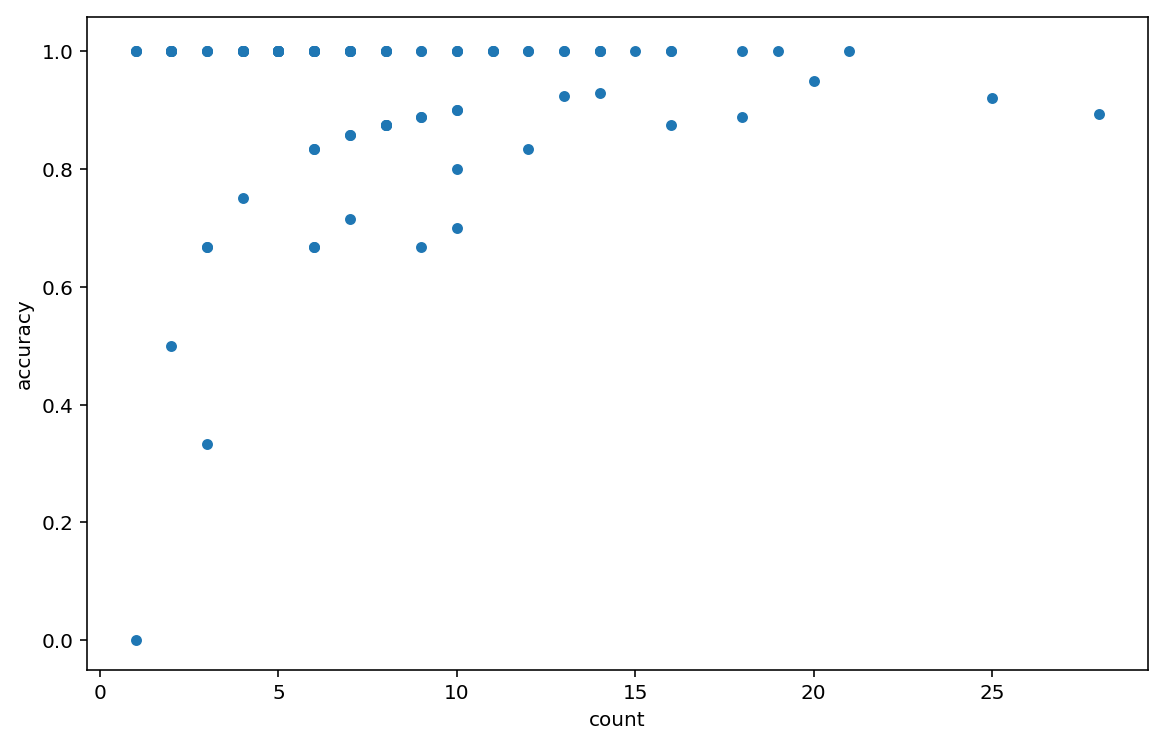

In [121]:
plt.rcParams['figure.figsize'] = [9.5, 6]

result.plot.scatter(x="count", y="accuracy")
plt.ylim(ymin=-0.05)  
plt.show()

### Chart with jitter augmentation and lr annealing
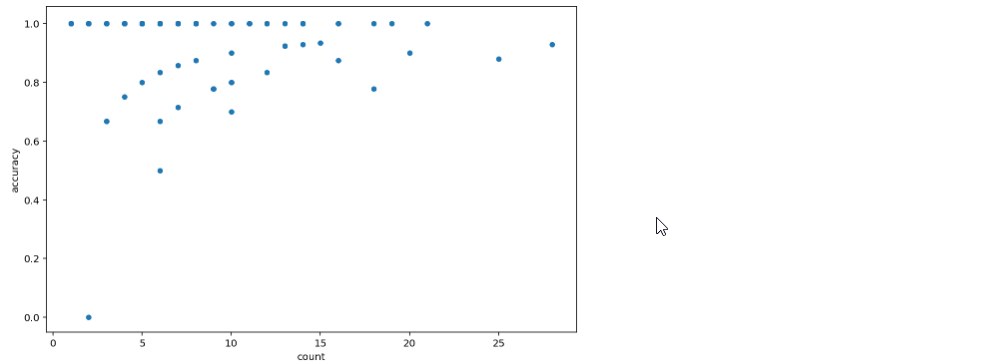

### Chart with lr annealing:
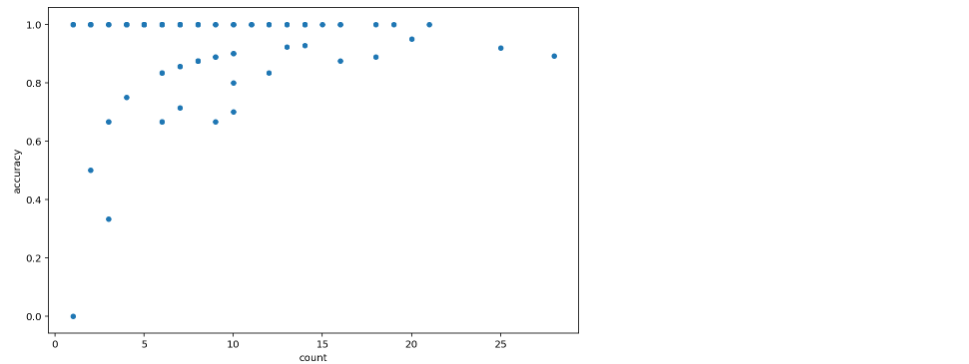


### Chart with weights and no lr annealing:
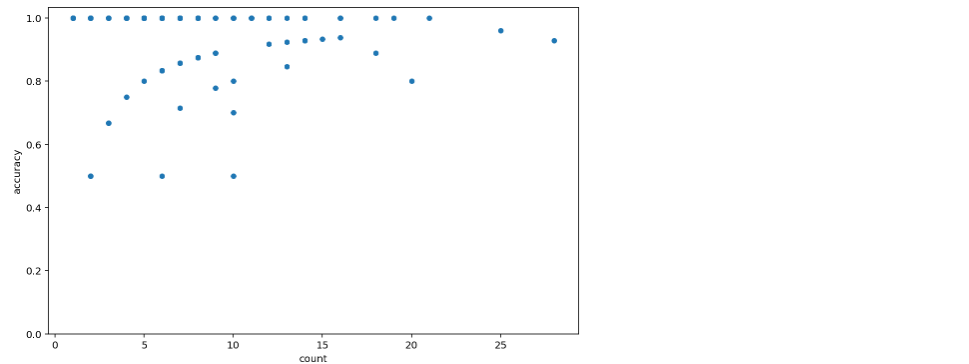

### Chart with weights and jitter and lr annealing
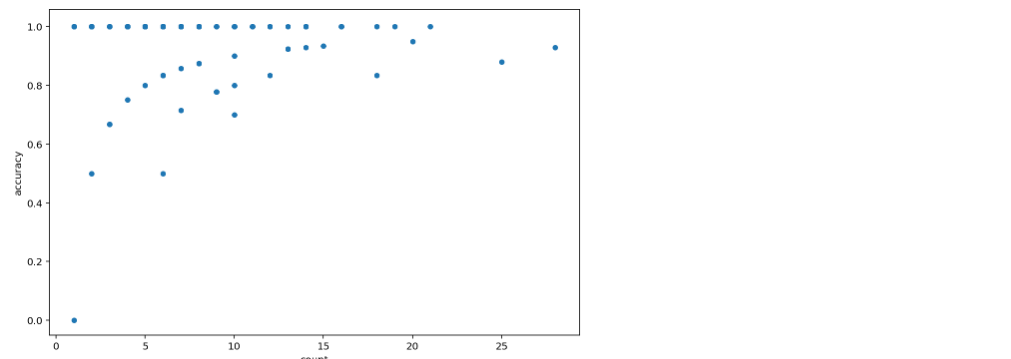

### Evaluate model - method 3

In [122]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    mean_list = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            
            equals = predicted == labels.data
            
            if idx == 0:
                print(equals)
            
            mean_list.append(equals.float().mean())
            
            print(equals.float().mean())
   
    print()
    print('Mean of all batches: {0:.4f}'.format(sum(mean_list) / len(mean_list)))

In [123]:
calc_accuracy(model, 'valid')

tensor([53, 15, 60, 48, 82, 50, 82, 16, 90, 97, 87, 82, 73, 66, 20,  5, 26, 43,
        97, 78, 76, 46, 77, 14, 30, 84, 84, 85, 39, 43, 97, 89, 73, 84, 83, 91,
         9, 98, 56, 77, 37, 89, 82, 83, 45, 43, 99, 71, 73, 50, 14,  0, 52, 11,
        11, 38, 97, 97, 76, 40, 76, 77, 38, 67])
tensor([1.1961e+00, 1.4808e-02, 8.5413e+01, 1.4182e+02, 6.8149e+02, 3.0390e+01,
        2.2586e+03, 1.0375e+00, 1.5278e+01, 6.2170e+00, 1.2842e+01, 1.2103e+02,
        3.0499e+00, 7.6058e+00, 1.4043e+01, 5.9507e+01, 2.9501e-01, 2.0147e+01,
        8.4381e-01, 1.1935e+00, 8.2110e-01, 7.5700e+01, 4.0726e+02, 5.7876e+03,
        4.2204e+02, 1.7792e-01, 5.6141e+01, 2.5580e-01, 1.0989e-01, 3.6986e+01,
        1.6390e+00, 2.5775e+01, 2.0150e+01, 3.8020e-01, 1.6898e-01, 4.9437e+00,
        2.1027e+02, 3.3085e-01, 8.3869e+01, 2.8532e+03, 3.8763e+00, 8.4177e+03,
        7.3584e+00, 2.2709e+00, 4.8656e+00, 3.2176e+00, 1.0698e+00, 2.4683e+03,
        5.4288e+00, 2.4750e+00, 3.7575e+01, 5.6757e-01, 9.3250e+02, 2.2

### Valid accuracy with lr annealing:
```
tensor([51, 17,  0,  4, 60, 74, 83, 78, 23, 81, 75, 38, 49, 89,  1, 49, 62, 85,
        40, 96, 77, 97, 30, 83, 76,  0, 59, 77, 41, 90, 19, 41, 47, 94, 15, 99,
        49, 53, 78, 48, 14, 12, 81,  5, 31, 49, 89,  0, 49, 84,  3, 38, 78, 77,
        26, 97, 21,  3, 55, 49, 49, 99, 89, 49], device='cuda:0')
tensor([7.7560e-01, 4.4296e+02, 2.3886e+00, 2.7603e+03, 1.2989e+01, 1.3506e+01,
        1.4440e-01, 1.5501e+01, 7.3592e+00, 5.7069e+01, 1.3035e+01, 4.2997e+01,
        6.4303e+01, 4.6027e-01, 2.9890e+05, 5.7312e-01, 7.3860e+02, 4.7929e-02,
        7.7617e+00, 9.4595e-03, 2.8570e+01, 2.0673e+01, 7.0019e+02, 9.6422e-01,
        1.0582e+02, 7.7708e-02, 8.3157e+00, 5.8836e+00, 1.0677e+03, 3.2071e+03,
        2.0819e+01, 8.3443e-01, 6.2759e+00, 3.4034e+01, 5.7900e+01, 3.0784e+00,
        3.5993e+00, 2.6784e+00, 4.1556e-02, 2.0324e+03, 1.3903e+00, 3.9471e+00,
        2.6042e+00, 3.5558e-02, 1.0118e+05, 2.2349e+01, 3.2784e+01, 1.1986e+01,
        7.5351e+01, 1.3435e+02, 2.7104e-01, 1.8285e+04, 8.6267e-01, 3.3454e+01,
        9.1917e-02, 6.9272e+01, 1.9707e+01, 1.1669e+00, 1.6662e+01, 1.4626e-02,
        3.6379e+01, 1.0036e+00, 1.2261e+00, 1.2253e+00], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8)
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9200, device='cuda:0')

Mean of all batches: 0.9422
```

In [124]:
calc_accuracy(model, 'test')

tensor([ 0, 66,  0, 49,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  5, 43,  5,  5,  5,  5,  5,  5,  5,  6,
         6, 18,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,
         9,  9,  9, 10, 10, 10, 11, 11, 11, 11])
tensor([1.5370e+02, 1.5397e+00, 4.7569e-01, 2.3888e-01, 1.0372e+01, 1.5134e+03,
        5.8295e+02, 9.1873e+03, 1.8862e+00, 5.0774e+02, 1.0596e+02, 1.3318e-01,
        1.6702e+03, 3.2242e+02, 4.3009e+01, 3.5352e+02, 2.0588e-01, 1.7816e+01,
        2.2466e+00, 1.8808e+00, 5.5459e+03, 1.2522e+03, 3.8375e+03, 7.1978e+02,
        6.9002e-01, 7.4803e+02, 8.8940e-01, 5.8403e-02, 2.3221e-01, 4.8985e-01,
        5.5782e-01, 6.8108e+00, 3.4016e-01, 1.2385e-01, 9.7252e-01, 8.1344e+03,
        1.4850e+05, 3.1475e-02, 1.4477e+03, 1.2091e-01, 1.2298e+04, 3.9841e+03,
        6.2544e+03, 3.4517e+03, 4.7368e+03, 5.3138e+02, 6.7829e+01, 1.3308e+03,
        9.8137e+00, 1.1044e-01, 5.8962e+01, 7.8390e+01, 2.6136e+03, 4.8

### Test accuracy with jitter augmentation and lr annealing
```
tensor([ 0, 66,  0, 49,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  5, 43,  5,  5,  5,  5,  5,  5,  5,  6,
         6, 18,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,
         9,  9,  9, 10, 10, 10, 11, 11, 11, 11])
tensor([1.5370e+02, 1.5397e+00, 4.7569e-01, 2.3888e-01, 1.0372e+01, 1.5134e+03,
        5.8295e+02, 9.1873e+03, 1.8862e+00, 5.0774e+02, 1.0596e+02, 1.3318e-01,
        1.6702e+03, 3.2242e+02, 4.3009e+01, 3.5352e+02, 2.0588e-01, 1.7816e+01,
        2.2466e+00, 1.8808e+00, 5.5459e+03, 1.2522e+03, 3.8375e+03, 7.1978e+02,
        6.9002e-01, 7.4803e+02, 8.8940e-01, 5.8403e-02, 2.3221e-01, 4.8985e-01,
        5.5782e-01, 6.8108e+00, 3.4016e-01, 1.2385e-01, 9.7252e-01, 8.1344e+03,
        1.4850e+05, 3.1475e-02, 1.4477e+03, 1.2091e-01, 1.2298e+04, 3.9841e+03,
        6.2544e+03, 3.4517e+03, 4.7368e+03, 5.3138e+02, 6.7829e+01, 1.3308e+03,
        9.8137e+00, 1.1044e-01, 5.8962e+01, 7.8390e+01, 2.6136e+03, 4.8439e+01,
        2.2729e+00, 5.4207e+01, 2.3748e-01, 4.9122e+00, 1.0565e-02, 3.5596e-03,
        1.3589e+02, 1.5836e+01, 3.7794e+02, 4.1105e+00])
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)
tensor(0.9375)
tensor(0.9531)
tensor(0.8906)
tensor(0.9219)
tensor(0.9531)
tensor(0.8906)
tensor(0.9531)
tensor(0.9062)
tensor(0.9531)
tensor(0.9688)
tensor(0.9219)
tensor(0.9062)
tensor(0.8235)

Mean of all batches: 0.9215
```

### Test accuracy with lr annealing:
```
tensor([ 0,  0,  0, 97,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  5, 43,  5,  5,  5,  5, 96, 15,  5,  6,
         6, 18,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,
         9,  9,  9, 10, 99, 95, 11, 11, 11, 11], device='cuda:0')
tensor([1.8345e+02, 2.7509e-01, 2.7678e-01, 5.3982e-02, 8.9086e+00, 4.9991e+02,
        4.1549e+02, 1.8176e+03, 2.5417e-01, 5.1910e+01, 1.0031e+02, 8.2986e-03,
        3.1783e+02, 9.3169e+01, 2.5133e+01, 1.7325e+02, 1.9284e-01, 3.5052e+01,
        1.1498e+01, 1.1978e+01, 1.4879e+03, 3.9380e+02, 6.2596e+02, 5.5326e+01,
        1.0148e+00, 1.2427e+02, 1.6082e+00, 2.6783e-02, 2.2548e-01, 9.2760e-01,
        2.4566e+00, 4.1587e+00, 2.2898e-01, 3.9258e-02, 1.5795e+00, 2.9423e+03,
        2.2926e+04, 2.3416e-02, 1.5616e+03, 1.5950e-02, 3.4220e+03, 3.3406e+02,
        3.9935e+02, 1.4841e+03, 2.4792e+03, 2.5131e+02, 2.4584e+01, 2.4647e+02,
        3.7961e+00, 1.8940e-02, 1.2014e+01, 3.2941e+01, 5.3117e+02, 7.6414e+00,
        5.8034e-01, 1.7926e+01, 5.1983e-02, 3.5505e+00, 8.6337e-03, 1.0081e-03,
        5.4850e+01, 1.9046e+00, 1.3437e+02, 5.3503e-01], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8)
tensor(0.8906, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8627, device='cuda:0')

Mean of all batches: 0.9342
```

In the output we have:
- The predicted flower type in the first tensor.
- The probability associated with how sure the model is that it has predicted the correct flower type.
- The truth of whether the model was actually correct or not.
- The accuracy for each batch.

In [125]:
for fruit in ['banana', 'orange', 'apple']:
    print(fruit)

banana
orange
apple


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

**See these for ideas:**

https://github.com/craig-martinson/aipnd-project

https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad

In [126]:
def resize_image(image, size):
    ''' Resize image so shortest side is 'size' pixels,
        maintain aspect ratio  
    '''
    w, h = image.size

    if h > w:
        # Set width to 'size' and scale height to maintain aspect ratio
        h = int(max(h * size / w, 1))
        w = int(size)
    else:
        # Set height to 'size' and scale width to maintain aspect ratio
        w = int(max(w * size / h, 1))
        h = int(size)

    return image.resize((w, h))


def crop_image(image, size):
    ''' Return a cropped square region from centre of image
    '''
    w, h = image.size
    x0 = (w - size) / 2
    y0 = (h - size) / 2
    x1 = x0 + size
    y1 = y0 + size

    return image.crop((x0, y0, x1, y1))

def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    
    # Resize image so shortest side is 256 pixels
    img = resize_image(img, 256)
    
    # Crop image
    img = crop_image(img, 224)

    # Normalize
    img = np.array(img)/255
    
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    # PIL assumes is the third dimension    
    img = img.transpose((2, 0, 1))
    
    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [127]:
testimg = process_image('flower_data/train/12/image_03999.jpg')

In [128]:
type(testimg)

numpy.ndarray

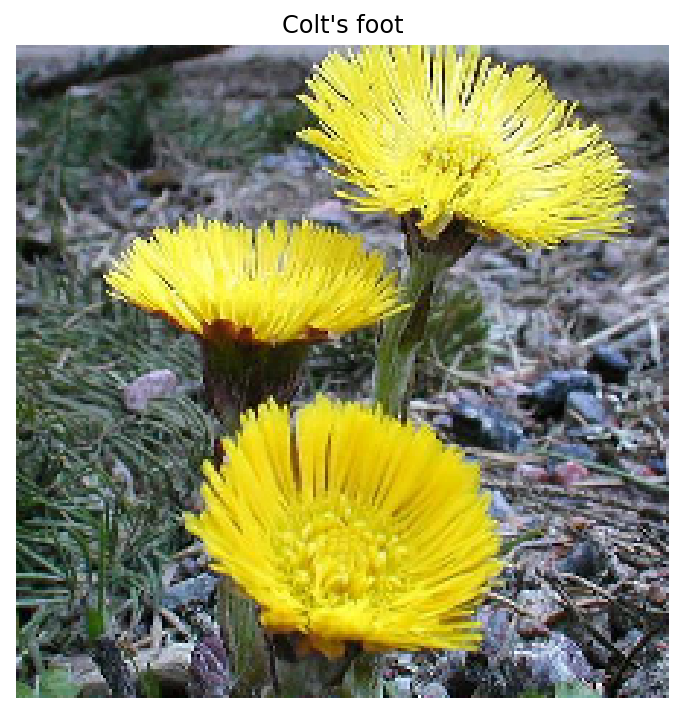

In [129]:
imshow(testimg, title="Colt's foot")

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [130]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img = process_image(image_path)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    
    # the first argument when passing an image tensor to the model needs to be the batch size 
    # for an individual image, using unsqueeze_(0) to add a 1 as the first argument of the tensor
    img_tensor.unsqueeze_(0)
    
    model.cpu()
    model.eval()
    
    with torch.no_grad():
        log_ps = model.forward(img_tensor)

        probs, classes = torch.topk(log_ps, k=topk)
        probs = torch.exp(probs) 

        probs = probs.detach().numpy().tolist()[0]
        classes = classes.detach().numpy().tolist()[0]

        idx_to_class =  {y:x for x,y in model.class_to_idx.items()}
        classes = [idx_to_class[ii] for ii in classes]
        classnames = [cat_to_name[cls] for cls in classes]
        
    return probs, classes, classnames        

In [131]:
imgpth = 'flower_data/train/12/image_03999.jpg'
pred = predict(imgpth, model)
print(pred)
print()
print(pred[0])
print()
print(pred[1])
print()
print(pred[2])

([2.8201467990875244, 0.07089203596115112, 0.008711426518857479, 0.008641985245049, 0.00783609040081501], ['12', '14', '29', '50', '83'], ["colt's foot", 'spear thistle', 'artichoke', 'common dandelion', 'hibiscus'])

[2.8201467990875244, 0.07089203596115112, 0.008711426518857479, 0.008641985245049, 0.00783609040081501]

['12', '14', '29', '50', '83']

["colt's foot", 'spear thistle', 'artichoke', 'common dandelion', 'hibiscus']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [132]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (4,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]

    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

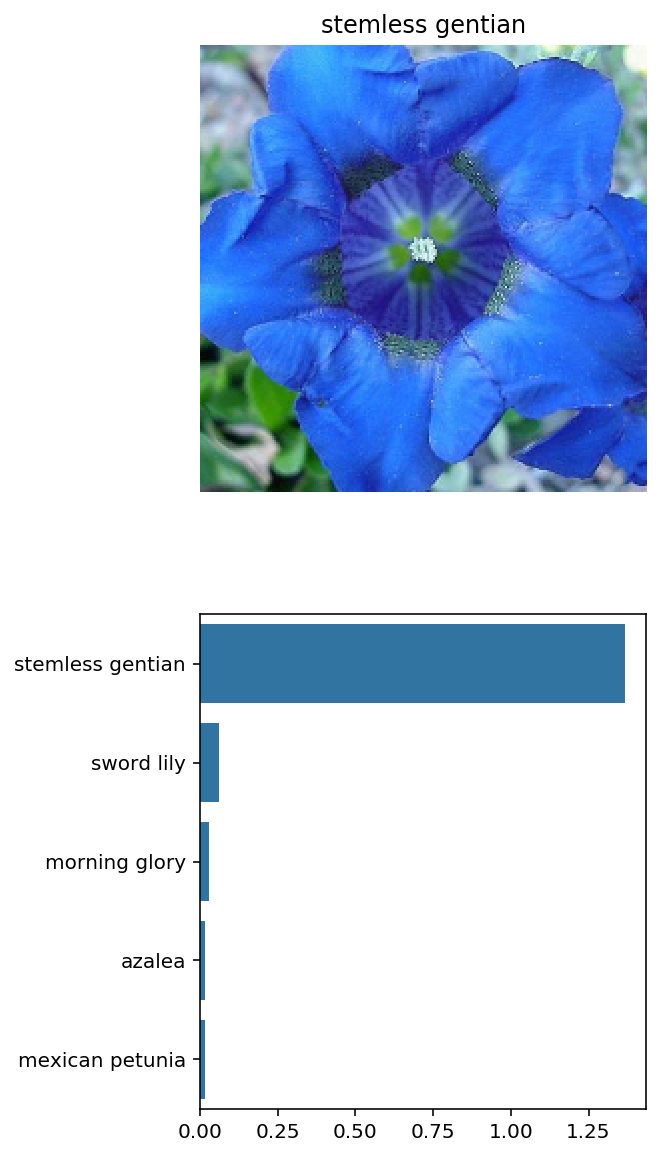

In [133]:
image_path = 'flower_data/valid/28/image_05258.jpg'
plot_solution(image_path, model)

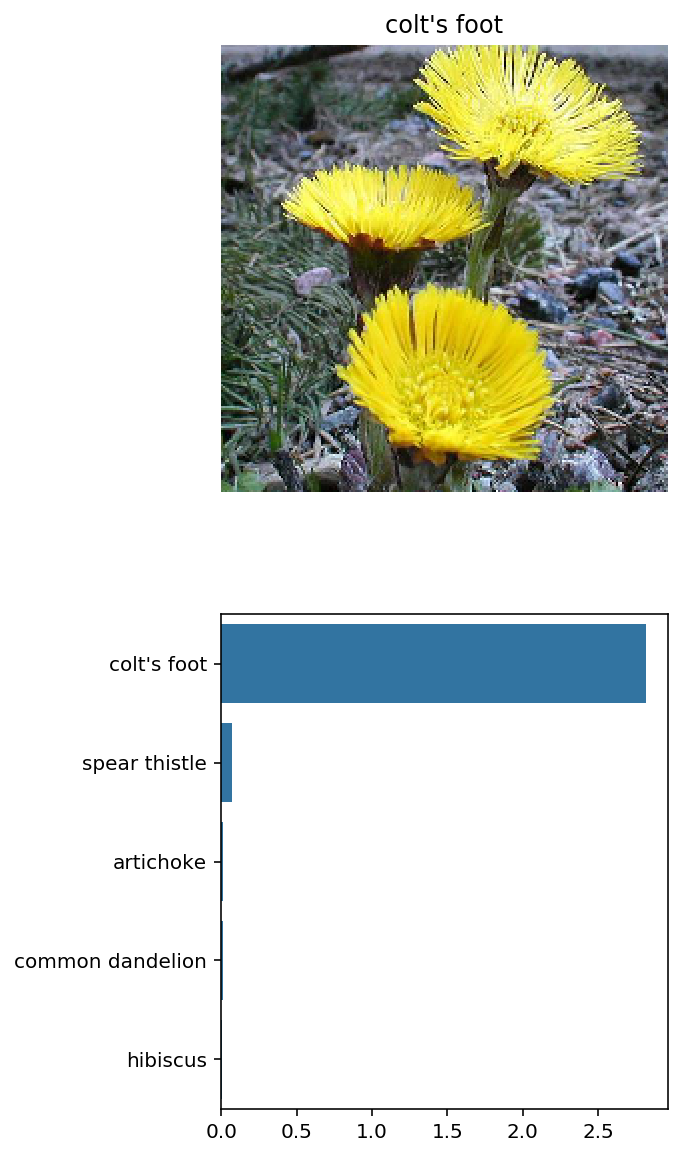

In [134]:
plot_solution('flower_data/train/12/image_03999.jpg', model)

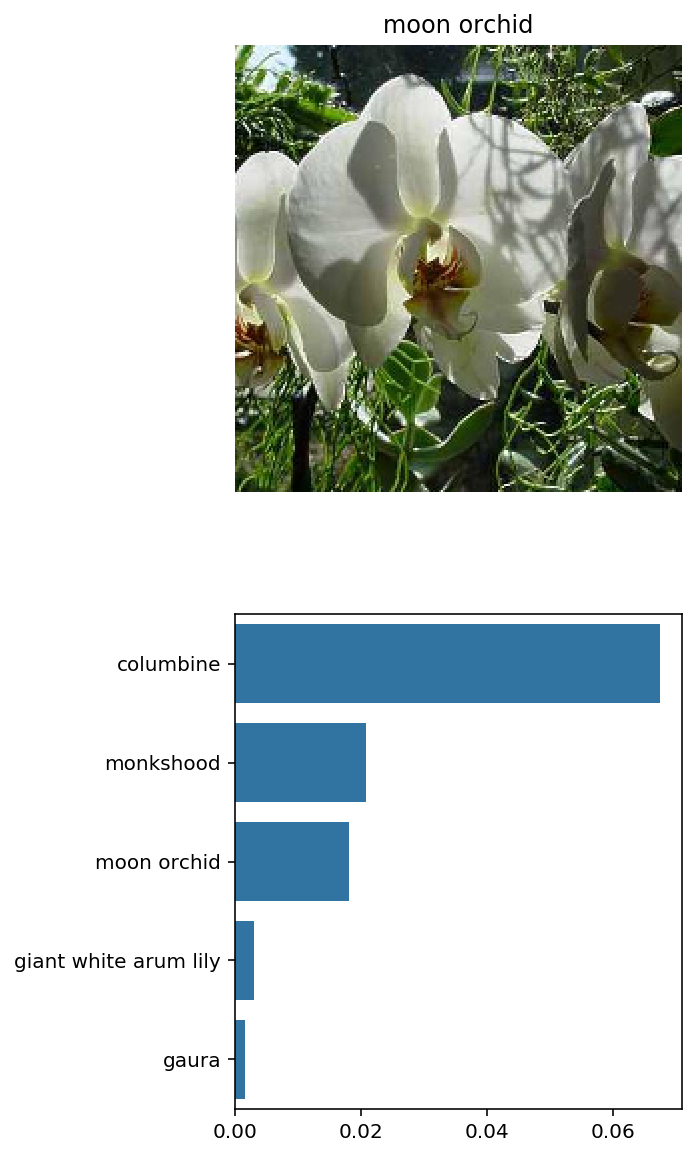

In [135]:
plot_solution('flower_data/valid/7/image_07216.jpg', model)

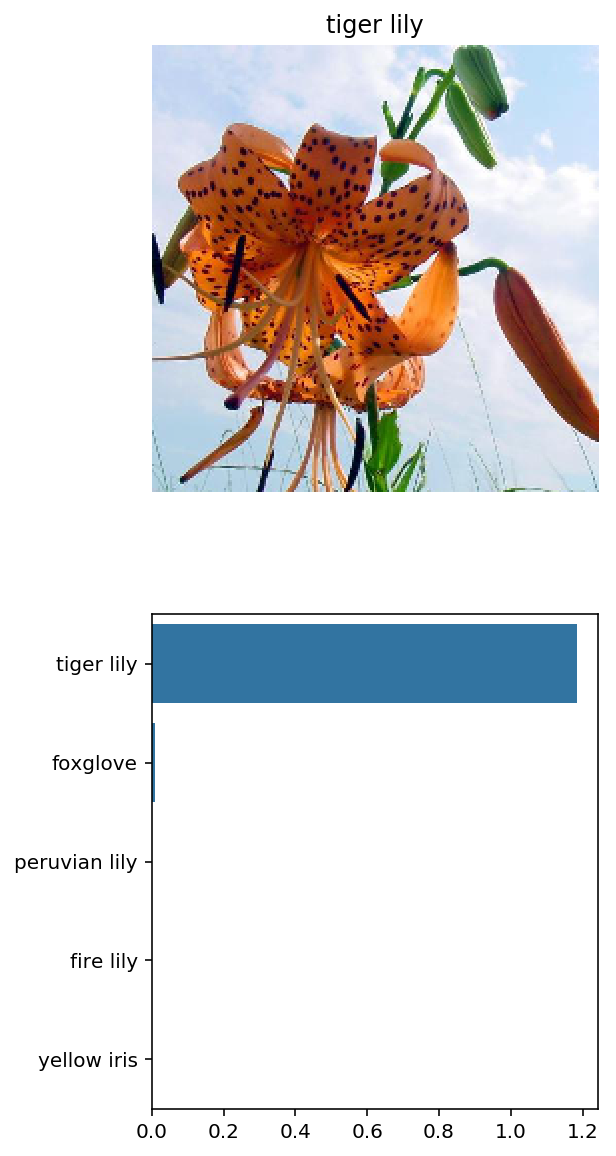

In [136]:
plot_solution('flower_data/valid/6/image_08105.jpg', model)

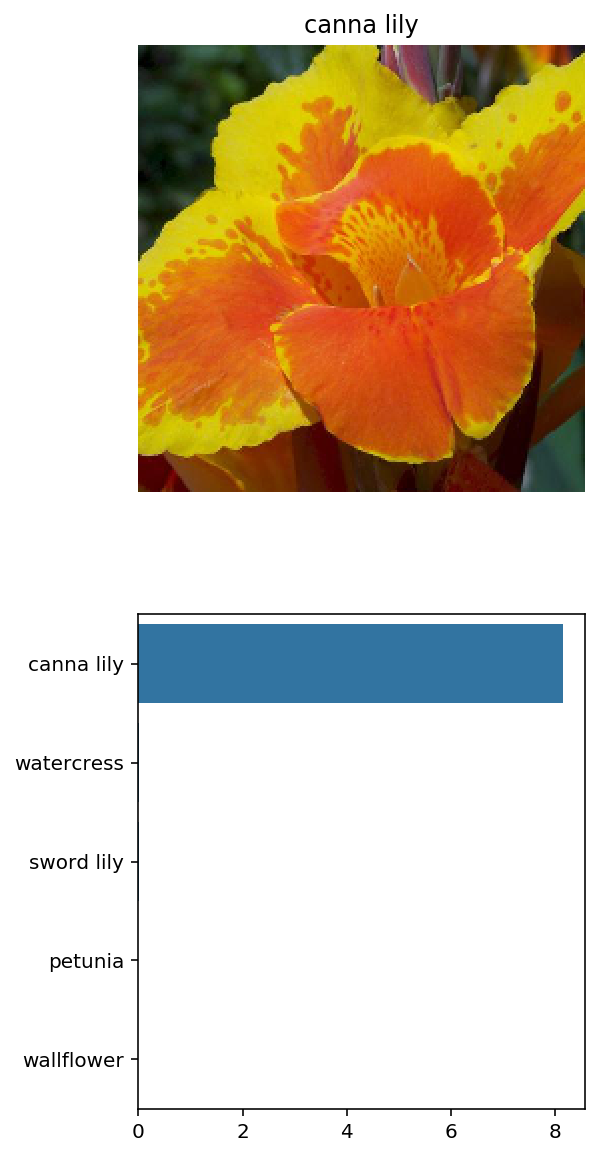

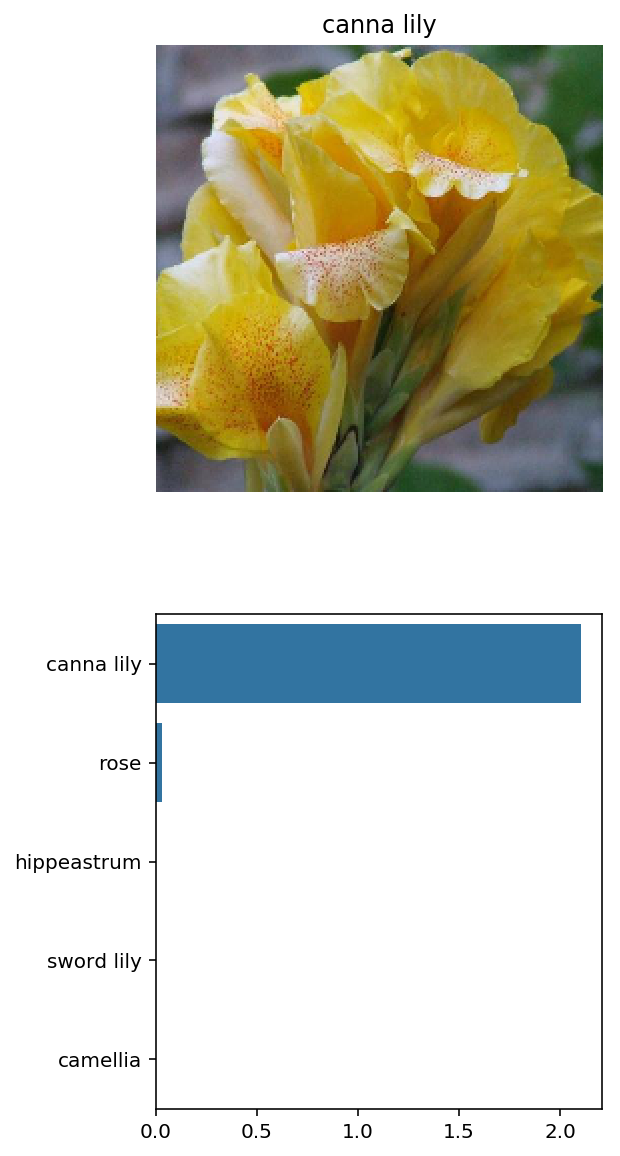

In [137]:
foldername = 'flower_data/valid/90/'
files = os.listdir(foldername)

for imgname in files:
    img = foldername + imgname
    plot_solution(img, model)

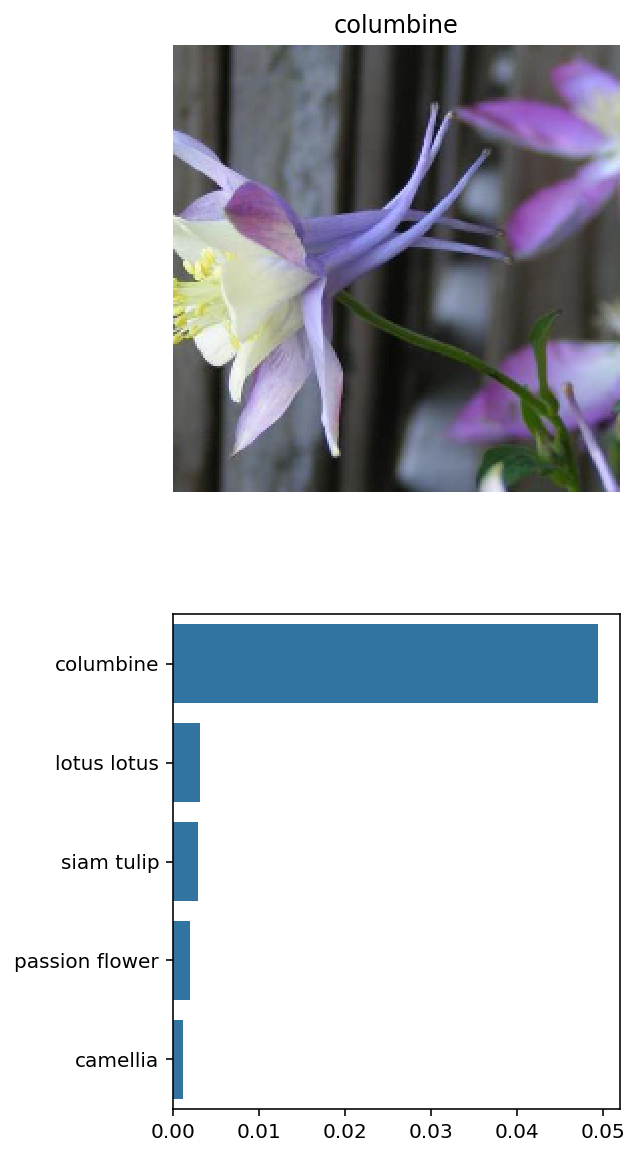

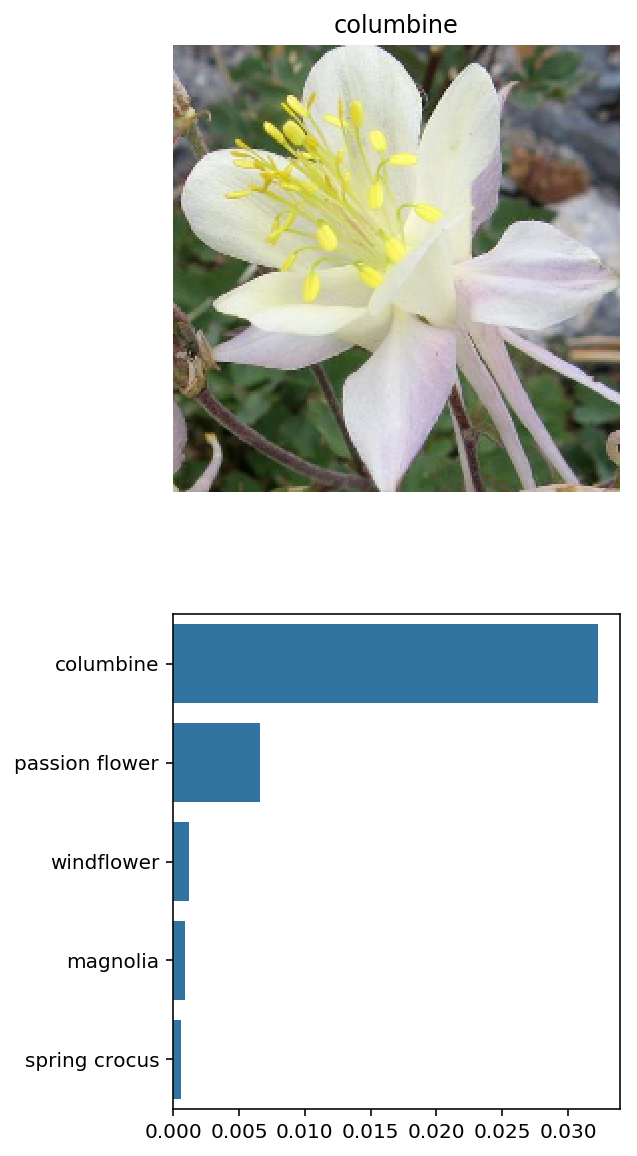

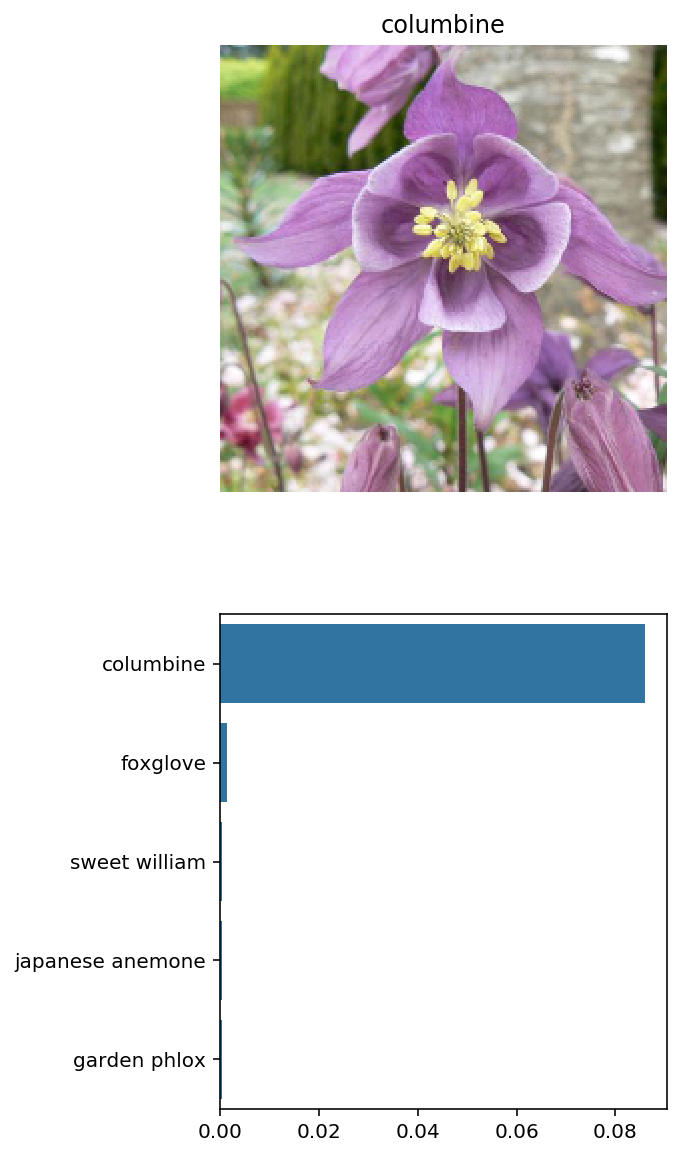

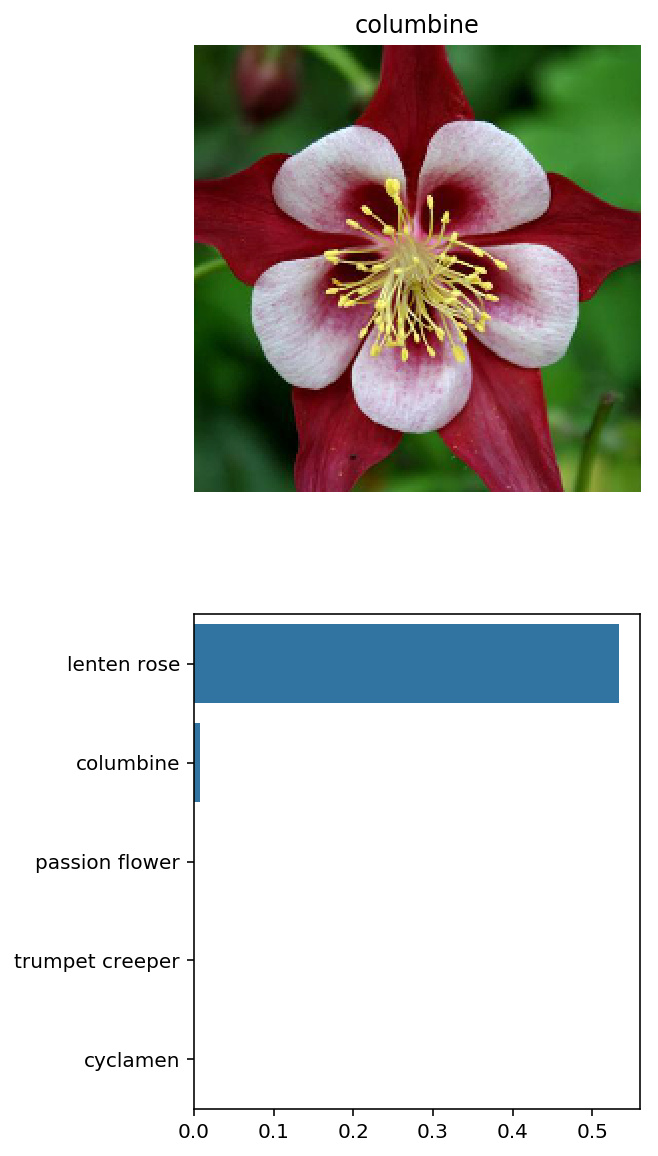

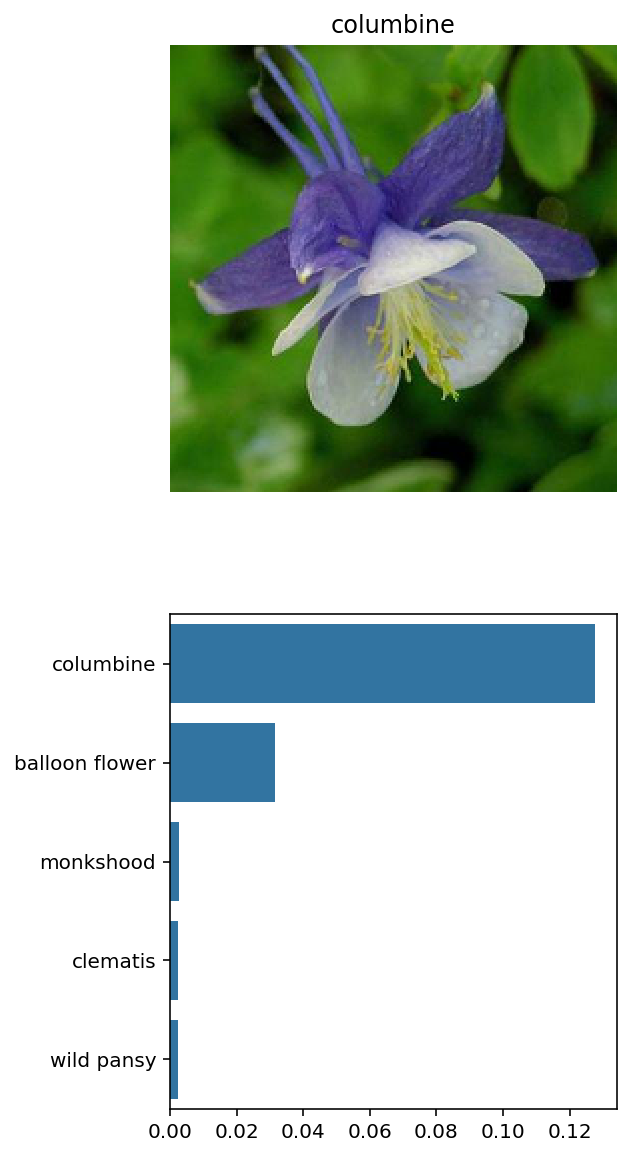

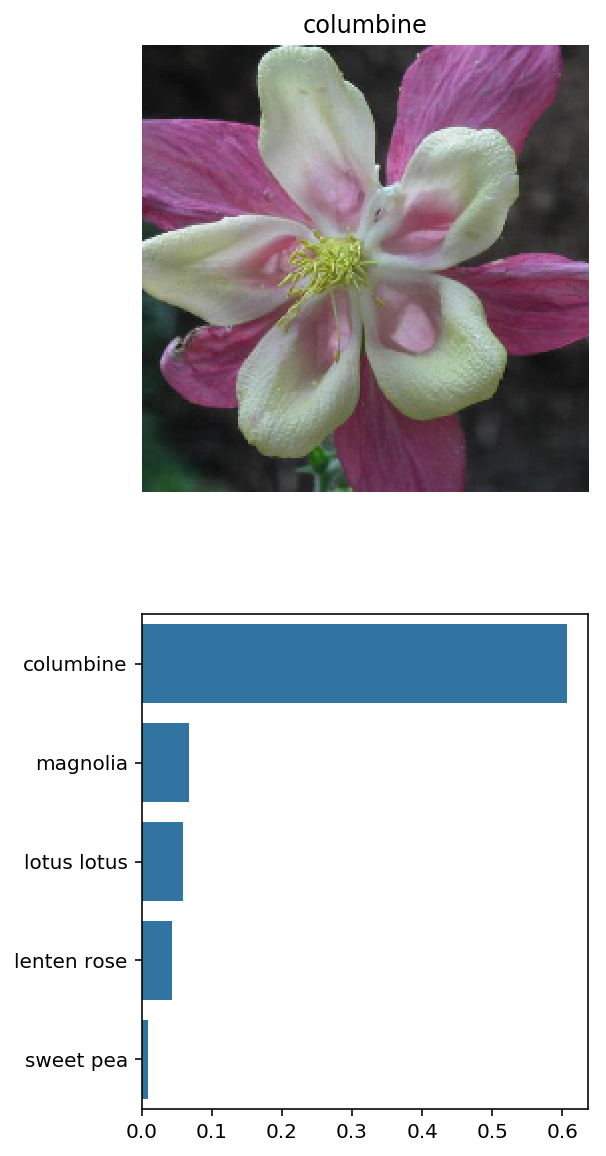

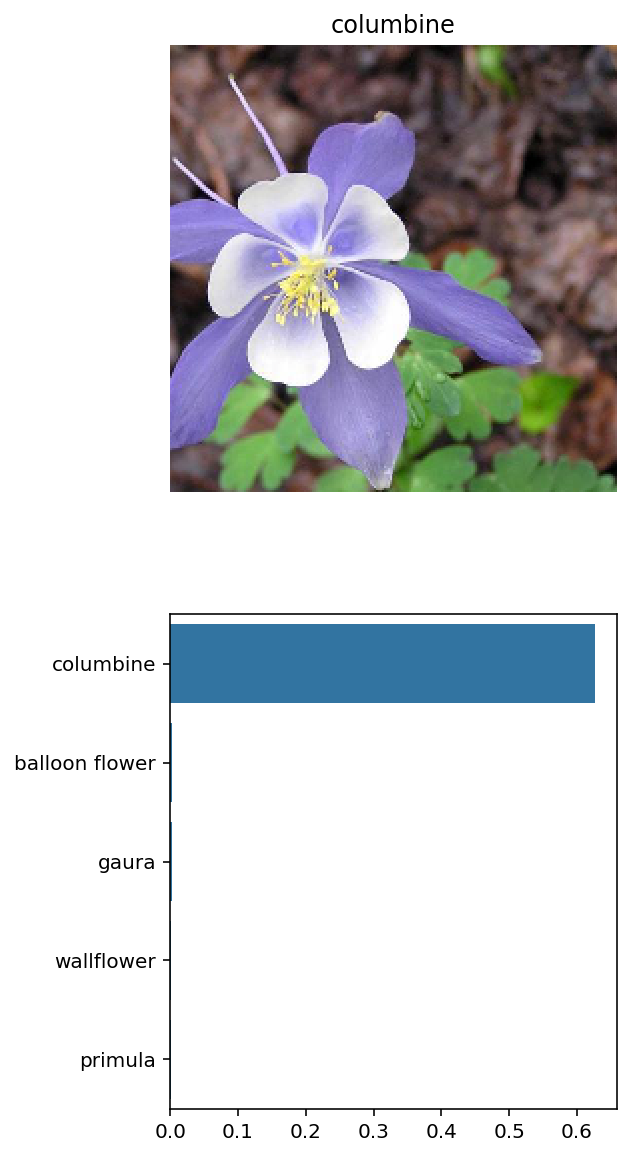

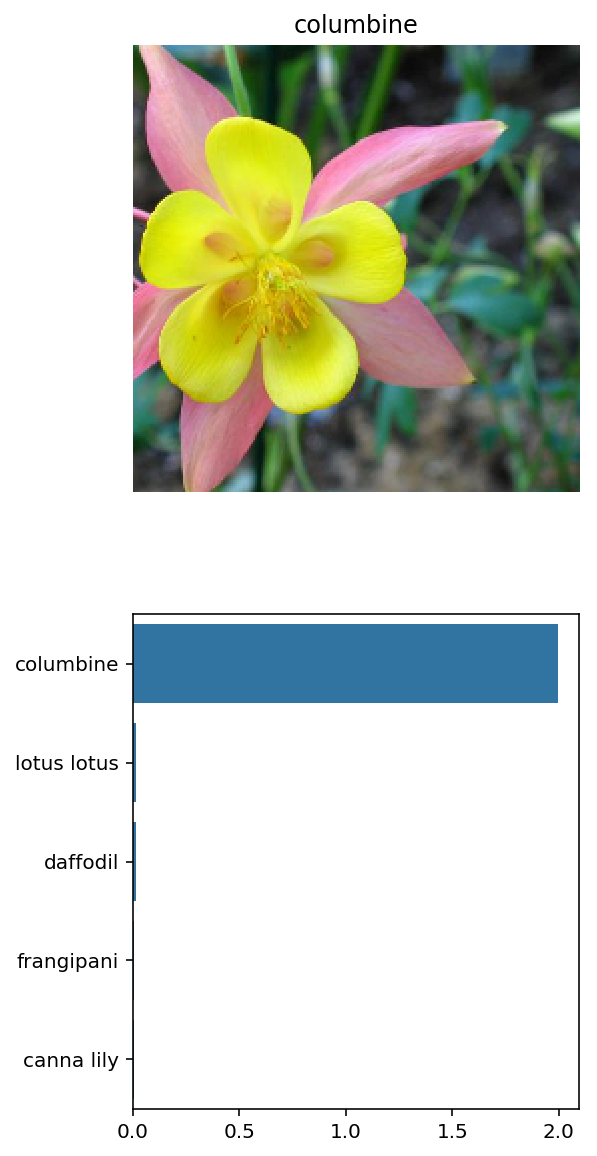

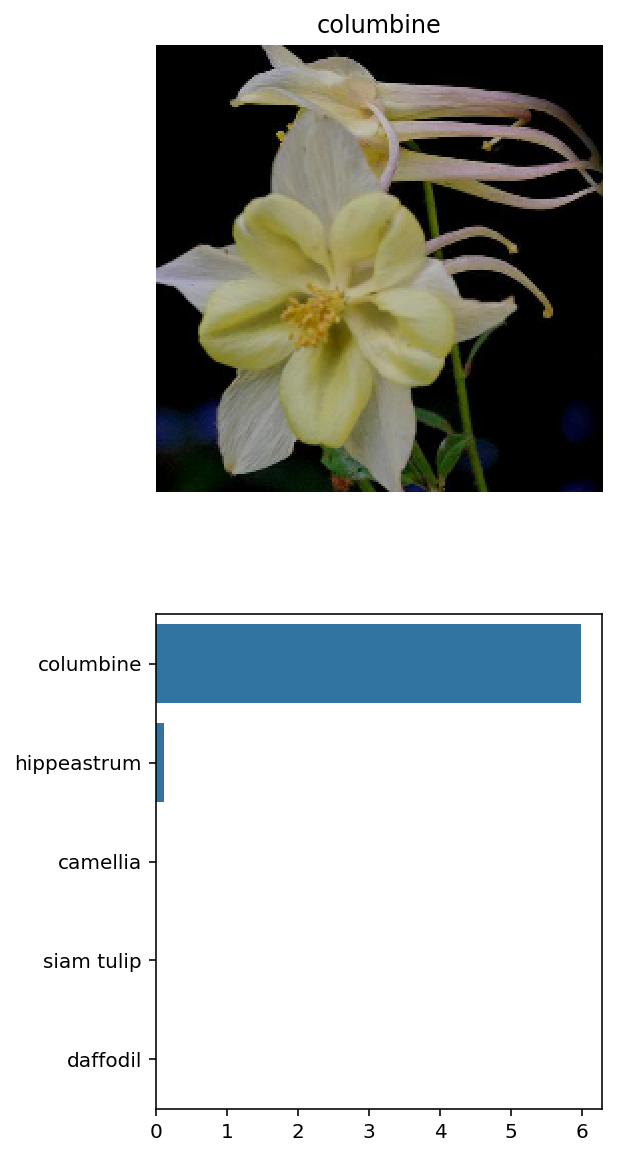

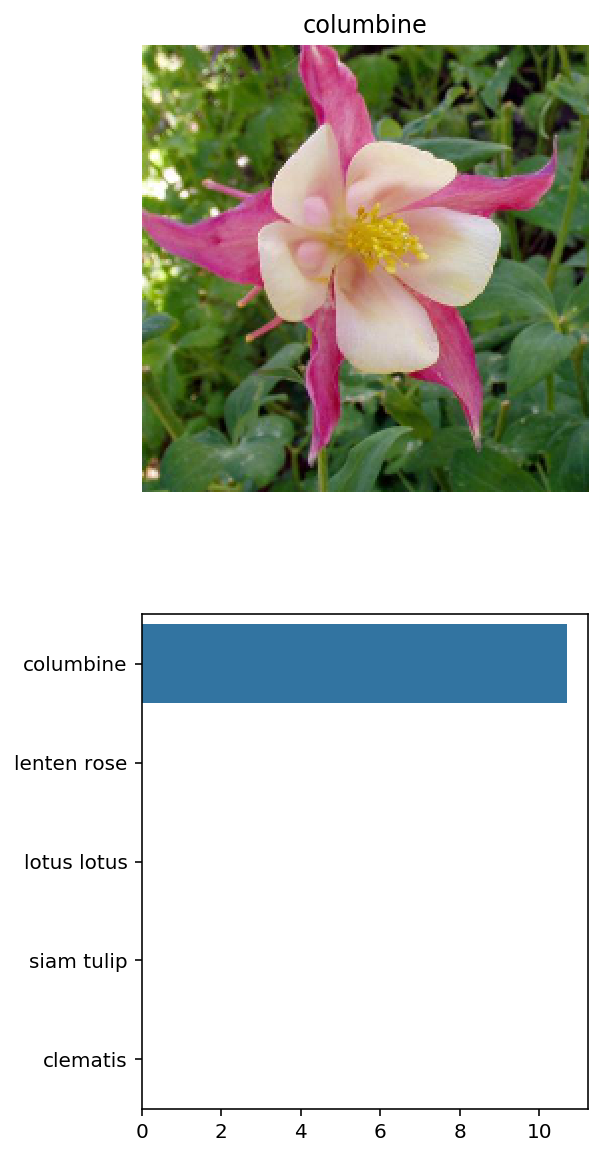

In [138]:
foldername = 'flower_data/valid/84/'
files = os.listdir(foldername)

for imgname in files:
    img = foldername + imgname
    plot_solution(img, model)

# Appendix

In [139]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>

## Loading for evaluation:
```
import torch
import torch.nn as nn
from torchvision import models

# If you used something other than 224x224 cropped images, set the correct size here
image_size = 224
# Values you used for normalizing the images. Default here are for 
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

def get_resnet50_model():
    resnetmodel = models.resnet50(pretrained=True)
    
    for param in resnetmodel.parameters():
        param.requires_grad = False    
        
    classifier_input_size = resnetmodel.fc.in_features
    classifier_output_size = 102 
    classifier = nn.Linear(classifier_input_size, classifier_output_size)
    
    resnetmodel.fc = classifier
    
    state_dicts_name = '/home/workspace/resnet50_24_epochs_model_and_opt.pth'
    
    state_dicts = torch.load(state_dicts_name, map_location='cpu')
    
    resnetmodel.load_state_dict(state_dicts['model_statedict'], strict=False)
    
    return resnetmodel 

model = get_resnet50_model()

```

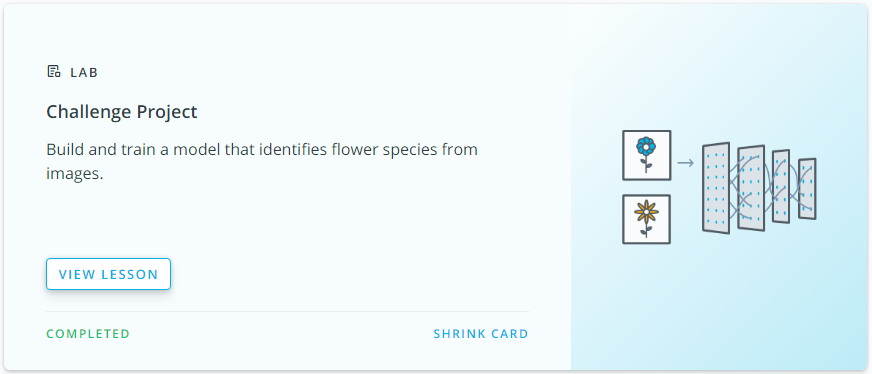